In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy.stats import pearsonr
from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.DataFrame
import optuna

from matplotlib.colors import LinearSegmentedColormap

import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
np.set_printoptions(linewidth=100)
#torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 100)

In [3]:
#base_path = '/home/sam/Desktop/logs_server/computed_numpy/convnextv2_atto.fcmae_2024_02_07-19_30_14.pt'
#base_path = '/home/sam/Desktop/logs_server/computed_numpy/convnextv2_atto.fcmae_2024_02_28-14_18_29'
#base_path = '/home/sam/Desktop/logs_server/computed_numpy/efficientnet_b0_2024_03_08-10_03_43'
#base_path = '/home/sam/Desktop/logs_server/computed_numpy/efficientnet_b0_2024_03_09-09_31_04'
base_path = '/home/sam/Desktop/logs_server/computed_numpy/efficientnet_b0_2024_03_10-16_03_41'

In [4]:
pred = np.load(os.path.join(base_path, 'pred.npy'))
loss = np.load(os.path.join(base_path, 'loss.npy'))
label = np.load(os.path.join(base_path,  'label.npy'))
calc_var = np.load(os.path.join(base_path, 'calc_var.npy'))
pred_var = np.load(os.path.join(base_path, 'pred_var.npy'))
spread = np.load(os.path.join(base_path, 'spread.npy'))

#pred = (np.log1p(pred) - 4) / 3
#pred = (pred * 2800) + 1085
#pred = (pred - 1085) / 2800
#pred = np.exp((pred - 1085) / 2800)
#pred = (pred * 7) - 4335.358032
pred_var = np.exp(pred_var)
#pred[np.where(pred < 0)] = 0.01
# calc_var = (calc_var-8.87) / 250_000
#pred = np.clip(pred, 0.01, None)

In [5]:
# Identify indices to keep (7% of label==0 entries)
indices_to_keep = np.where((label != 0) | (np.random.rand(len(label)) <= 0.07))

# Filter arrays using the identified indices
pred = pred[indices_to_keep]
loss = loss[indices_to_keep]
label = label[indices_to_keep]
calc_var = calc_var[indices_to_keep]
pred_var = pred_var[indices_to_keep]
spread = spread[indices_to_keep]


In [6]:

indices_to_keep = np.where(pred > 0)

# Filter arrays using the identified indices
pred = pred[indices_to_keep]
loss = loss[indices_to_keep]
label = label[indices_to_keep]
calc_var = calc_var[indices_to_keep]
pred_var = pred_var[indices_to_keep]
spread = spread[indices_to_keep]


In [7]:
def normalize_labels(labels, mean=1068, std=1792):
    """
    Normalizes the labels by applying Z-score normalization.
    """
    mean = 4
    std = 3
    log_labels = np.log1p(labels)
    log_norm_labels = (log_labels - mean) / std
    return log_norm_labels

In [8]:
calc_fano = calc_var / pred
calc_CV = np.sqrt(calc_var) / pred
calc_SNR = pred ** 2 / calc_var

pred_fano = pred_var / pred
pred_CV = np.sqrt(pred_var) / pred
pred_SNR = pred**2/pred_var

spread = spread

In [9]:
print(type(spread))

<class 'numpy.ndarray'>


In [10]:
data = {
    'Pred': pred,
    'Loss': loss,
    'Label': label,
    'Calc_var': calc_var,
    'Calc_fano': calc_fano,
    'Calc_CV': calc_CV,
    'Calc_SNR': calc_SNR,
    'Pred_var': pred_var,
    'Pred_fano': pred_fano,
    'Pred_CV': pred_CV,
    'Pred_SNR': pred_SNR,
    'Spread': spread
}

In [11]:
df = pd.DataFrame(data)
df.head()

Pred          Loss  Label  Calc_var     Calc_fano   Calc_CV      Calc_SNR  Pred_var  \
0  388.895020  34929.750000  202.0  0.000094  2.428177e-07  0.000025  1.601593e+09  0.006079   
1    7.909912     62.566711    0.0  0.000023  2.871487e-06  0.000603  2.754640e+06  0.000073   
2   20.281250    298.641602    3.0  0.000010  4.698540e-07  0.000152  4.316501e+07  0.000082   
3   36.172974      0.029920   36.0  0.000018  4.993384e-07  0.000117  7.244181e+07  0.000278   
4   75.005066  56166.597656  312.0  0.000041  5.494444e-07  0.000086  1.365107e+08  0.009682   

   Pred_fano   Pred_CV      Pred_SNR    Spread  
0   0.000016  0.000200  2.487813e+07  0.008557  
1   0.000009  0.001083  8.533322e+05  0.018939  
2   0.000004  0.000447  4.998884e+06  0.005219  
3   0.000008  0.000461  4.712187e+06  0.005293  
4   0.000129  0.001312  5.810458e+05  0.005282

In [12]:
df.describe()

Pred          Loss         Label      Calc_var     Calc_fano       Calc_CV  \
count  12916.000000  1.291600e+04  12916.000000  12916.000000  1.291600e+04  12916.000000   
mean    1849.206591  3.515049e+06   1640.739470      0.006110  1.305635e-06      0.000095   
std     3307.093387  2.063444e+07   3631.205296      0.018103  3.227900e-06      0.000644   
min        0.085327  4.306436e-06      0.000000      0.000006  5.560709e-08      0.000011   
25%       60.527435  7.552424e+02     32.000000      0.000020  2.568430e-07      0.000021   
50%      339.405060  1.867166e+04    208.000000      0.000071  5.734420e-07      0.000030   
75%     2033.779510  4.501018e+05   1518.250000      0.002589  1.554062e-06      0.000074   
max    24105.644531  7.290314e+08  44636.000000      0.266089  1.941339e-04      0.047699   

           Calc_SNR      Pred_var     Pred_fano       Pred_CV      Pred_SNR        Spread  
count  1.291600e+04  12916.000000  12916.000000  12916.000000  1.291600e+04  12916.000000  
mean   1.375319e+09      0.569778      0.000086      0.000478  2.763512e+07      0.047163  
std    1.281472e+09      2.701296      0.000171      0.002035  3.951644e+07      0.094927  
min    4.395272e+02      0.000030      0.000001      0.000040  5.490021e+01      0.001732  
25%    1.806972e+08      0.000684      0.000010      0.000166  4.035137e+06      0.004777  
50%    1.099229e+09      0.007111      0.000024      0.000263  1.447678e+07      0.011823  
75%    2.241882e+09      0.143088      0.000089      0.000498  3.610440e+07      0.046256  
max    7.975461e+09     82.554748      0.003492      0.134962  6.188239e+08      1.468936

In [13]:
df['Pred_var'].quantile(0.9999)

67.5726652487974

In [14]:
df.isna().sum().sum()

0

In [15]:
bins = 80

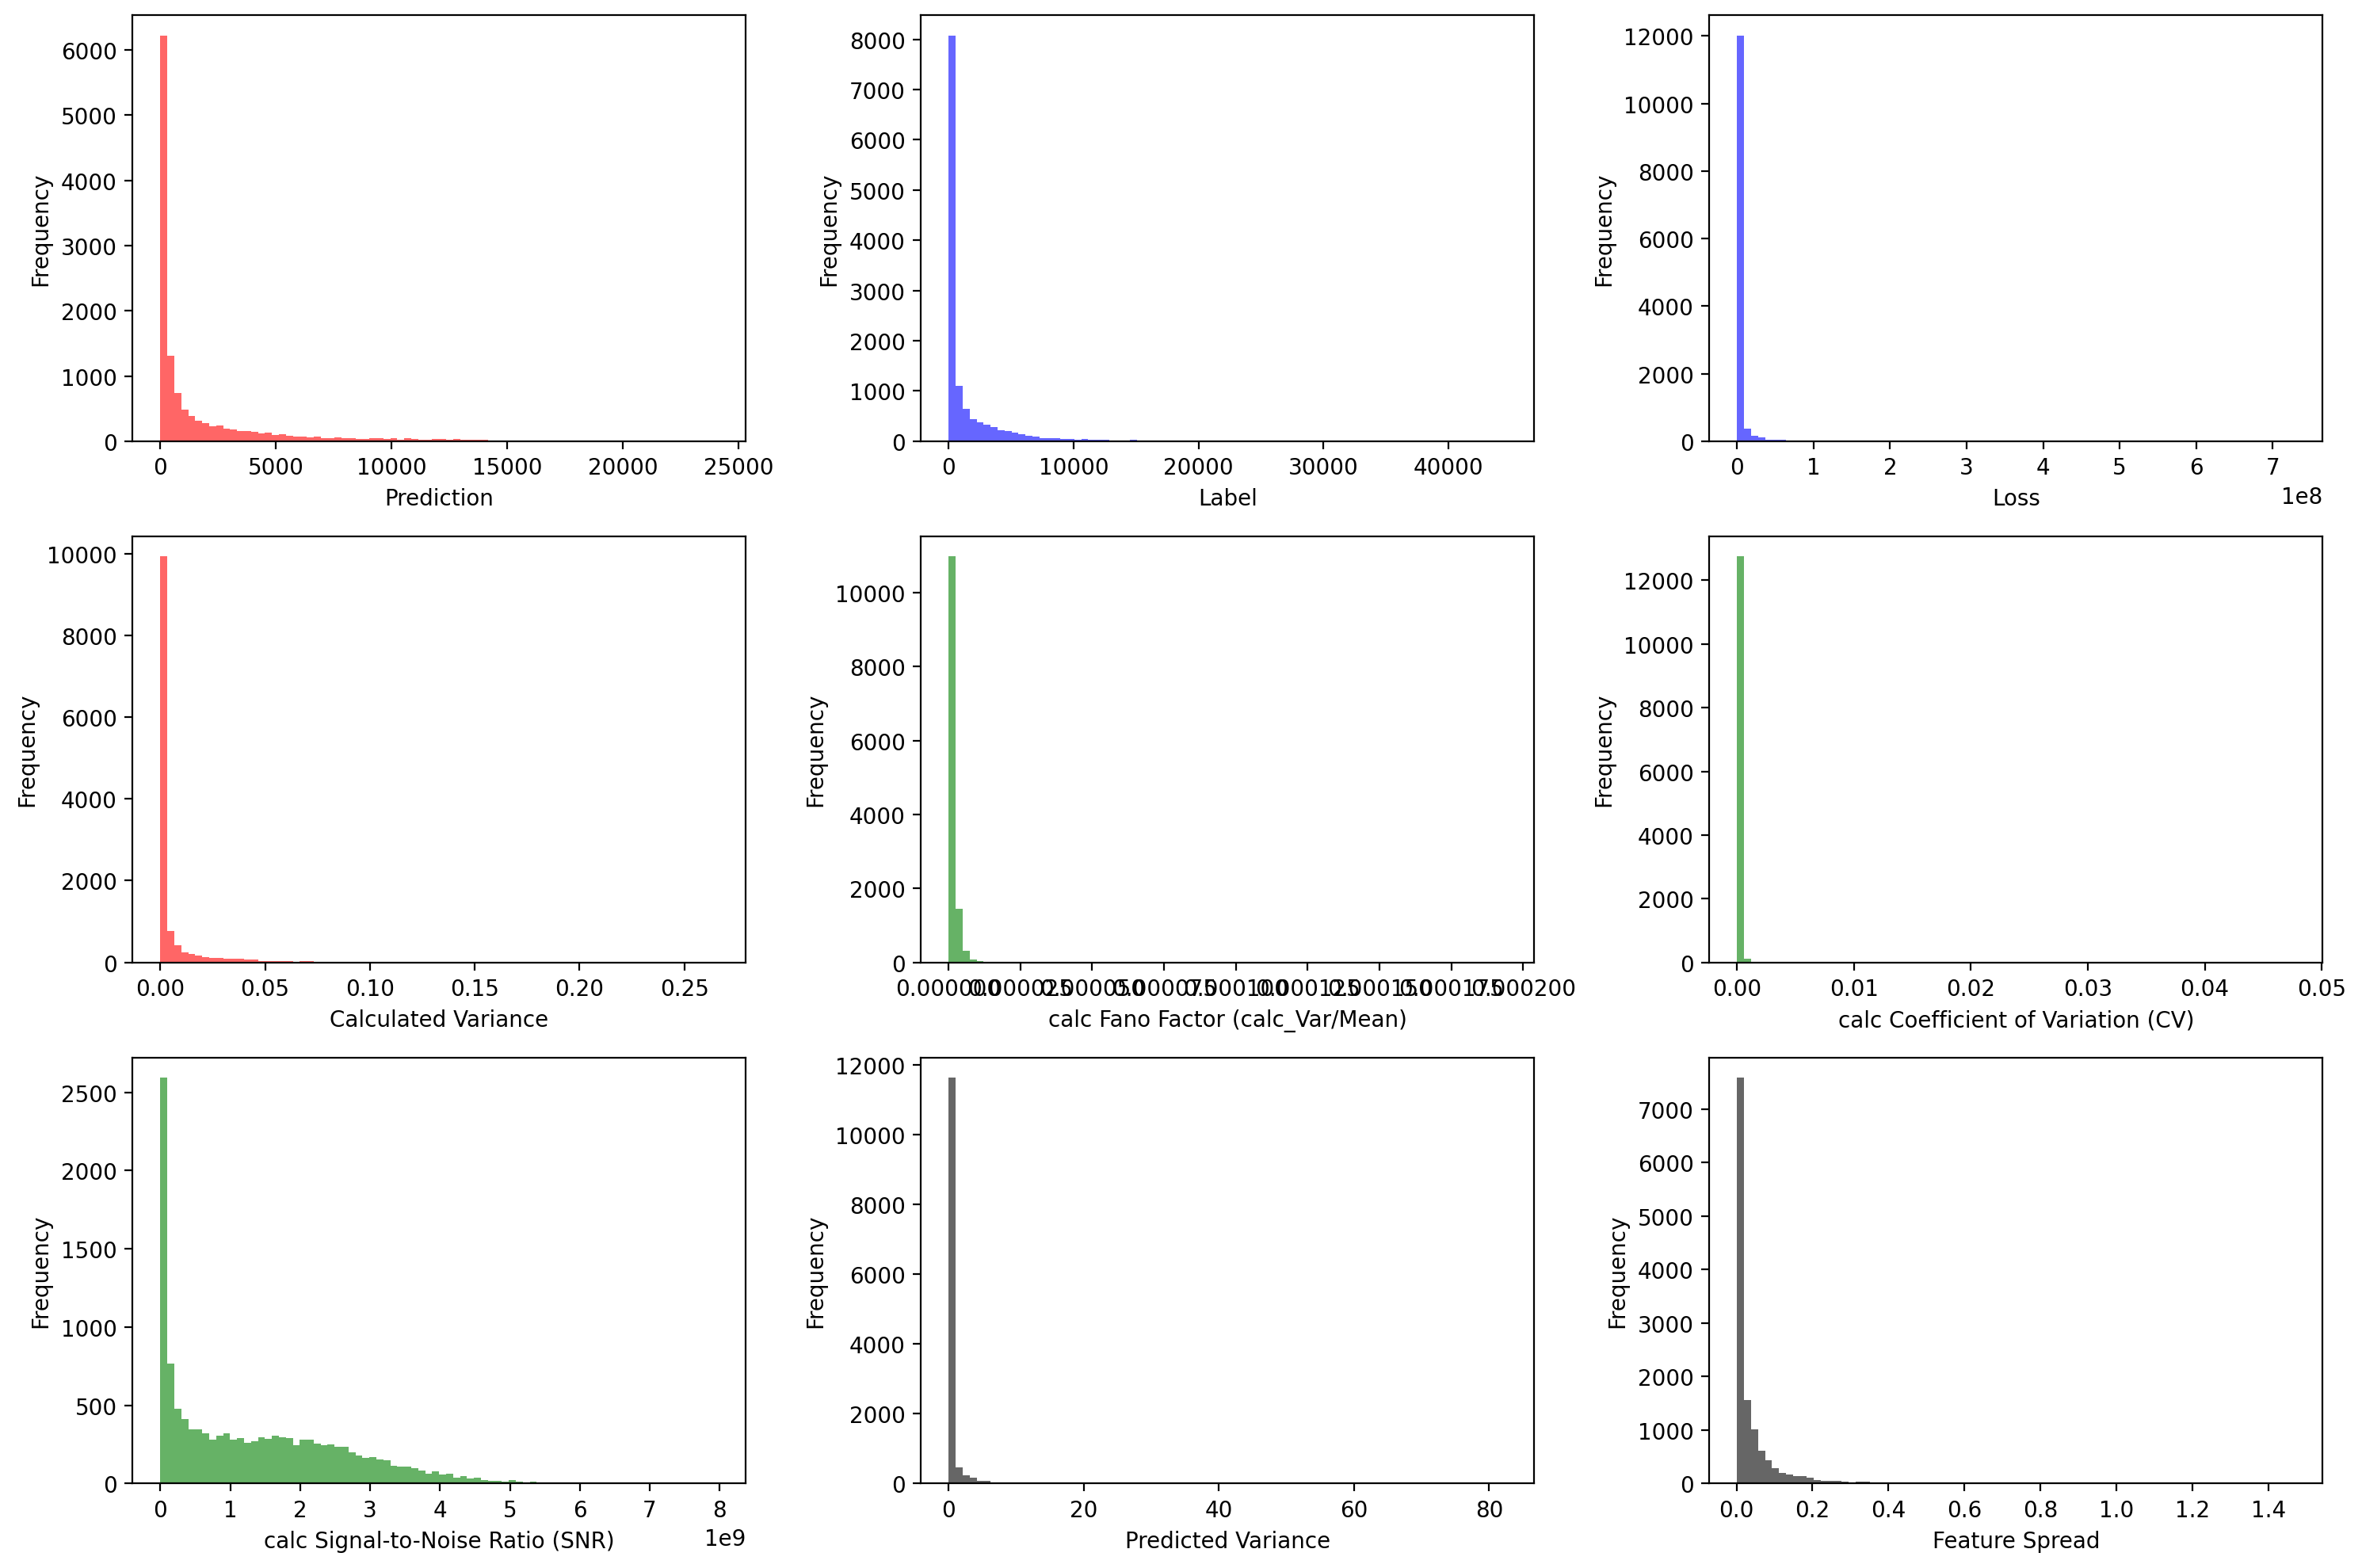

In [16]:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.hist(pred, bins=bins, color='red', alpha=0.6)
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
#ax1.set_yscale('log')

ax1 = plt.subplot(3, 3, 2)
ax1.hist(label, bins=bins, color='blue', alpha=0.6)
ax1.set_xlabel("Label")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
#ax1.set_yscale('log')

ax1 = plt.subplot(3, 3, 3)
ax1.hist(loss, bins=bins, color='blue', alpha=0.6)
ax1.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
#ax1.set_yscale('log')

ax2 = plt.subplot(3, 3, 4)
ax2.hist(calc_var, bins=bins, color='red', alpha=0.6)
ax2.set_xlabel("Calculated Variance")
ax2.set_ylabel("Frequency")
# ax2.set_xscale('log')
#ax2.set_yscale('log')

ax4 = plt.subplot(3, 3, 5)
ax4.hist(calc_fano, bins=bins, color='green', alpha=0.6)
ax4.set_xlabel("calc Fano Factor (calc_Var/Mean)")
ax4.set_ylabel("Frequency")
# ax4.set_xscale('log')
#ax4.set_yscale('log')

ax5 = plt.subplot(3, 3, 6)
ax5.hist(calc_CV, bins=bins, color='green', alpha=0.6)
ax5.set_xlabel("calc Coefficient of Variation (CV)")
ax5.set_ylabel("Frequency")
# ax5.set_xscale('log')
# ax5.set_yscale('log')

ax6 = plt.subplot(3, 3, 7)
ax6.hist(calc_SNR, bins=bins, color='green', alpha=0.6)
ax6.set_xlabel("calc Signal-to-Noise Ratio (SNR)")
ax6.set_ylabel("Frequency")
# ax6.set_xscale('log')
#ax6.set_yscale('log')

ax3 = plt.subplot(3, 3, 8)
ax3.hist(pred_var, bins=bins, color='black', alpha=0.6)
ax3.set_xlabel("Predicted Variance")
ax3.set_ylabel("Frequency")
#ax3.set_xscale('log')
# ax3.set_yscale('log')

ax3 = plt.subplot(3, 3, 9)
ax3.hist(spread, bins=bins, color='black', alpha=0.6)
ax3.set_xlabel("Feature Spread")
ax3.set_ylabel("Frequency")
# ax3.set_xscale('log')
# ax3.set_yscale('log')

plt.tight_layout()

In [17]:
"""
plt.figure(figsize=(10, 7))
plt.hist(spread, bins=bins, color='blue', alpha=0.6)
#ax1.set_title("Label")
plt.xlabel("Feature Spread", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('/home/sam/Desktop/Master_Thesis/HistFeatureSpread.png', format='png', dpi=200)
"""

'\nplt.figure(figsize=(10, 7))\nplt.hist(spread, bins=bins, color=\'blue\', alpha=0.6)\n#ax1.set_title("Label")\nplt.xlabel("Feature Spread", fontsize=24)\nplt.ylabel("Frequency", fontsize=24)\n#plt.xscale(\'log\')\n#plt.yscale(\'log\')\n#plt.savefig(\'/home/sam/Desktop/Master_Thesis/HistFeatureSpread.png\', format=\'png\', dpi=200)\n'

In [18]:
print(f"Pred:            {df['Pred'].skew()}")
print(f"Label:           {df['Label'].skew()}")
print(f"TeacherLoss:     {df['Loss'].skew()}")
print(f"calc_var:        {df['Calc_var'].skew()}")
print(f"pred_var:        {df['Pred_var'].skew()}")
print(f"Spread:          {df['Spread'].skew()}")

Pred:            2.7339032784219652
Label:           4.568330106364838
TeacherLoss:     16.28758004692216
calc_var:        5.641004825902979
pred_var:        12.61799660696231
Spread:          4.891413955761032


In [19]:
print(f"Pred:            {df['Pred'].kurt()}")
print(f"Label:           {df['Label'].kurt()}")
print(f"TeacherLoss:     {df['Loss'].kurt()}")
print(f"calc_var:        {df['Calc_var'].kurt()}")
print(f"pred_var:        {df['Pred_var'].kurt()}")
print(f"Spread:          {df['Spread'].kurt()}")

Pred:            8.313535932365989
Label:           28.894309969139837
TeacherLoss:     387.7979585965564
calc_var:        44.391249772314005
pred_var:        228.94817371082917
Spread:          34.34703662495536


In [20]:
target = df['Loss']
target_transformed = np.log1p(target)

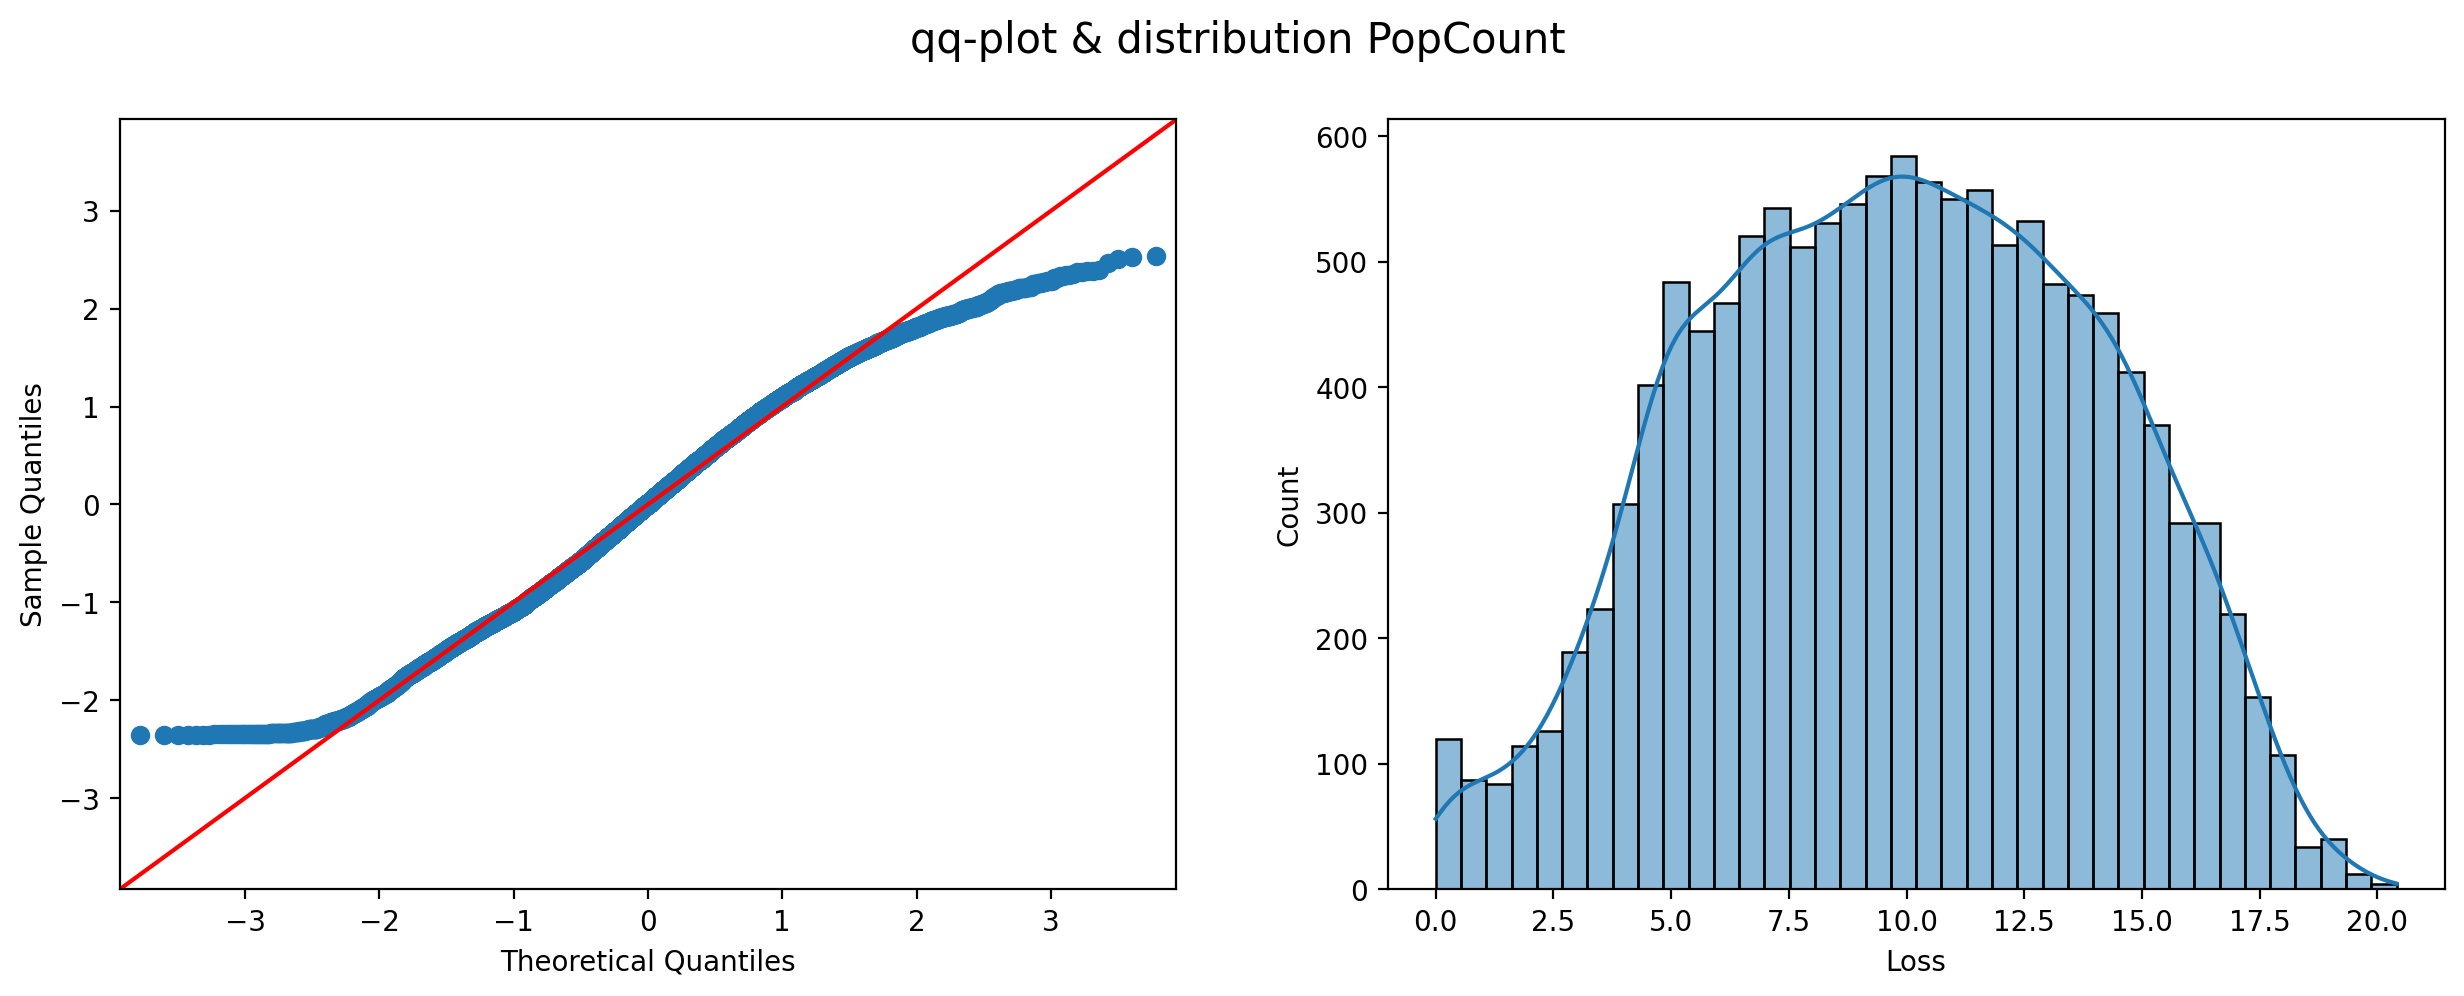

In [21]:
fig, ax = plt.subplots(1, 2, figsize= (15, 5))
fig.suptitle("qq-plot & distribution PopCount ", fontsize=15)

sm.qqplot(target_transformed, stats.t, distargs=(4,),fit=True, line="45", ax=ax[0])
sns.histplot(target_transformed, kde=True, ax=ax[1])
plt.show()

In [22]:
label_log1p = np.log1p(label)
loss = loss
loss2 = np.log(loss) / pred
loss3 = np.sqrt(loss) / (pred+1)
loss4 = loss / (pred+1)

In [23]:
data ['Loss2'] = loss2
data ['Loss3'] = loss3
data ['Loss4'] = loss4

In [24]:
df = pd.DataFrame(data)
#df.head()

In [25]:
corr_matrix = df.corr()

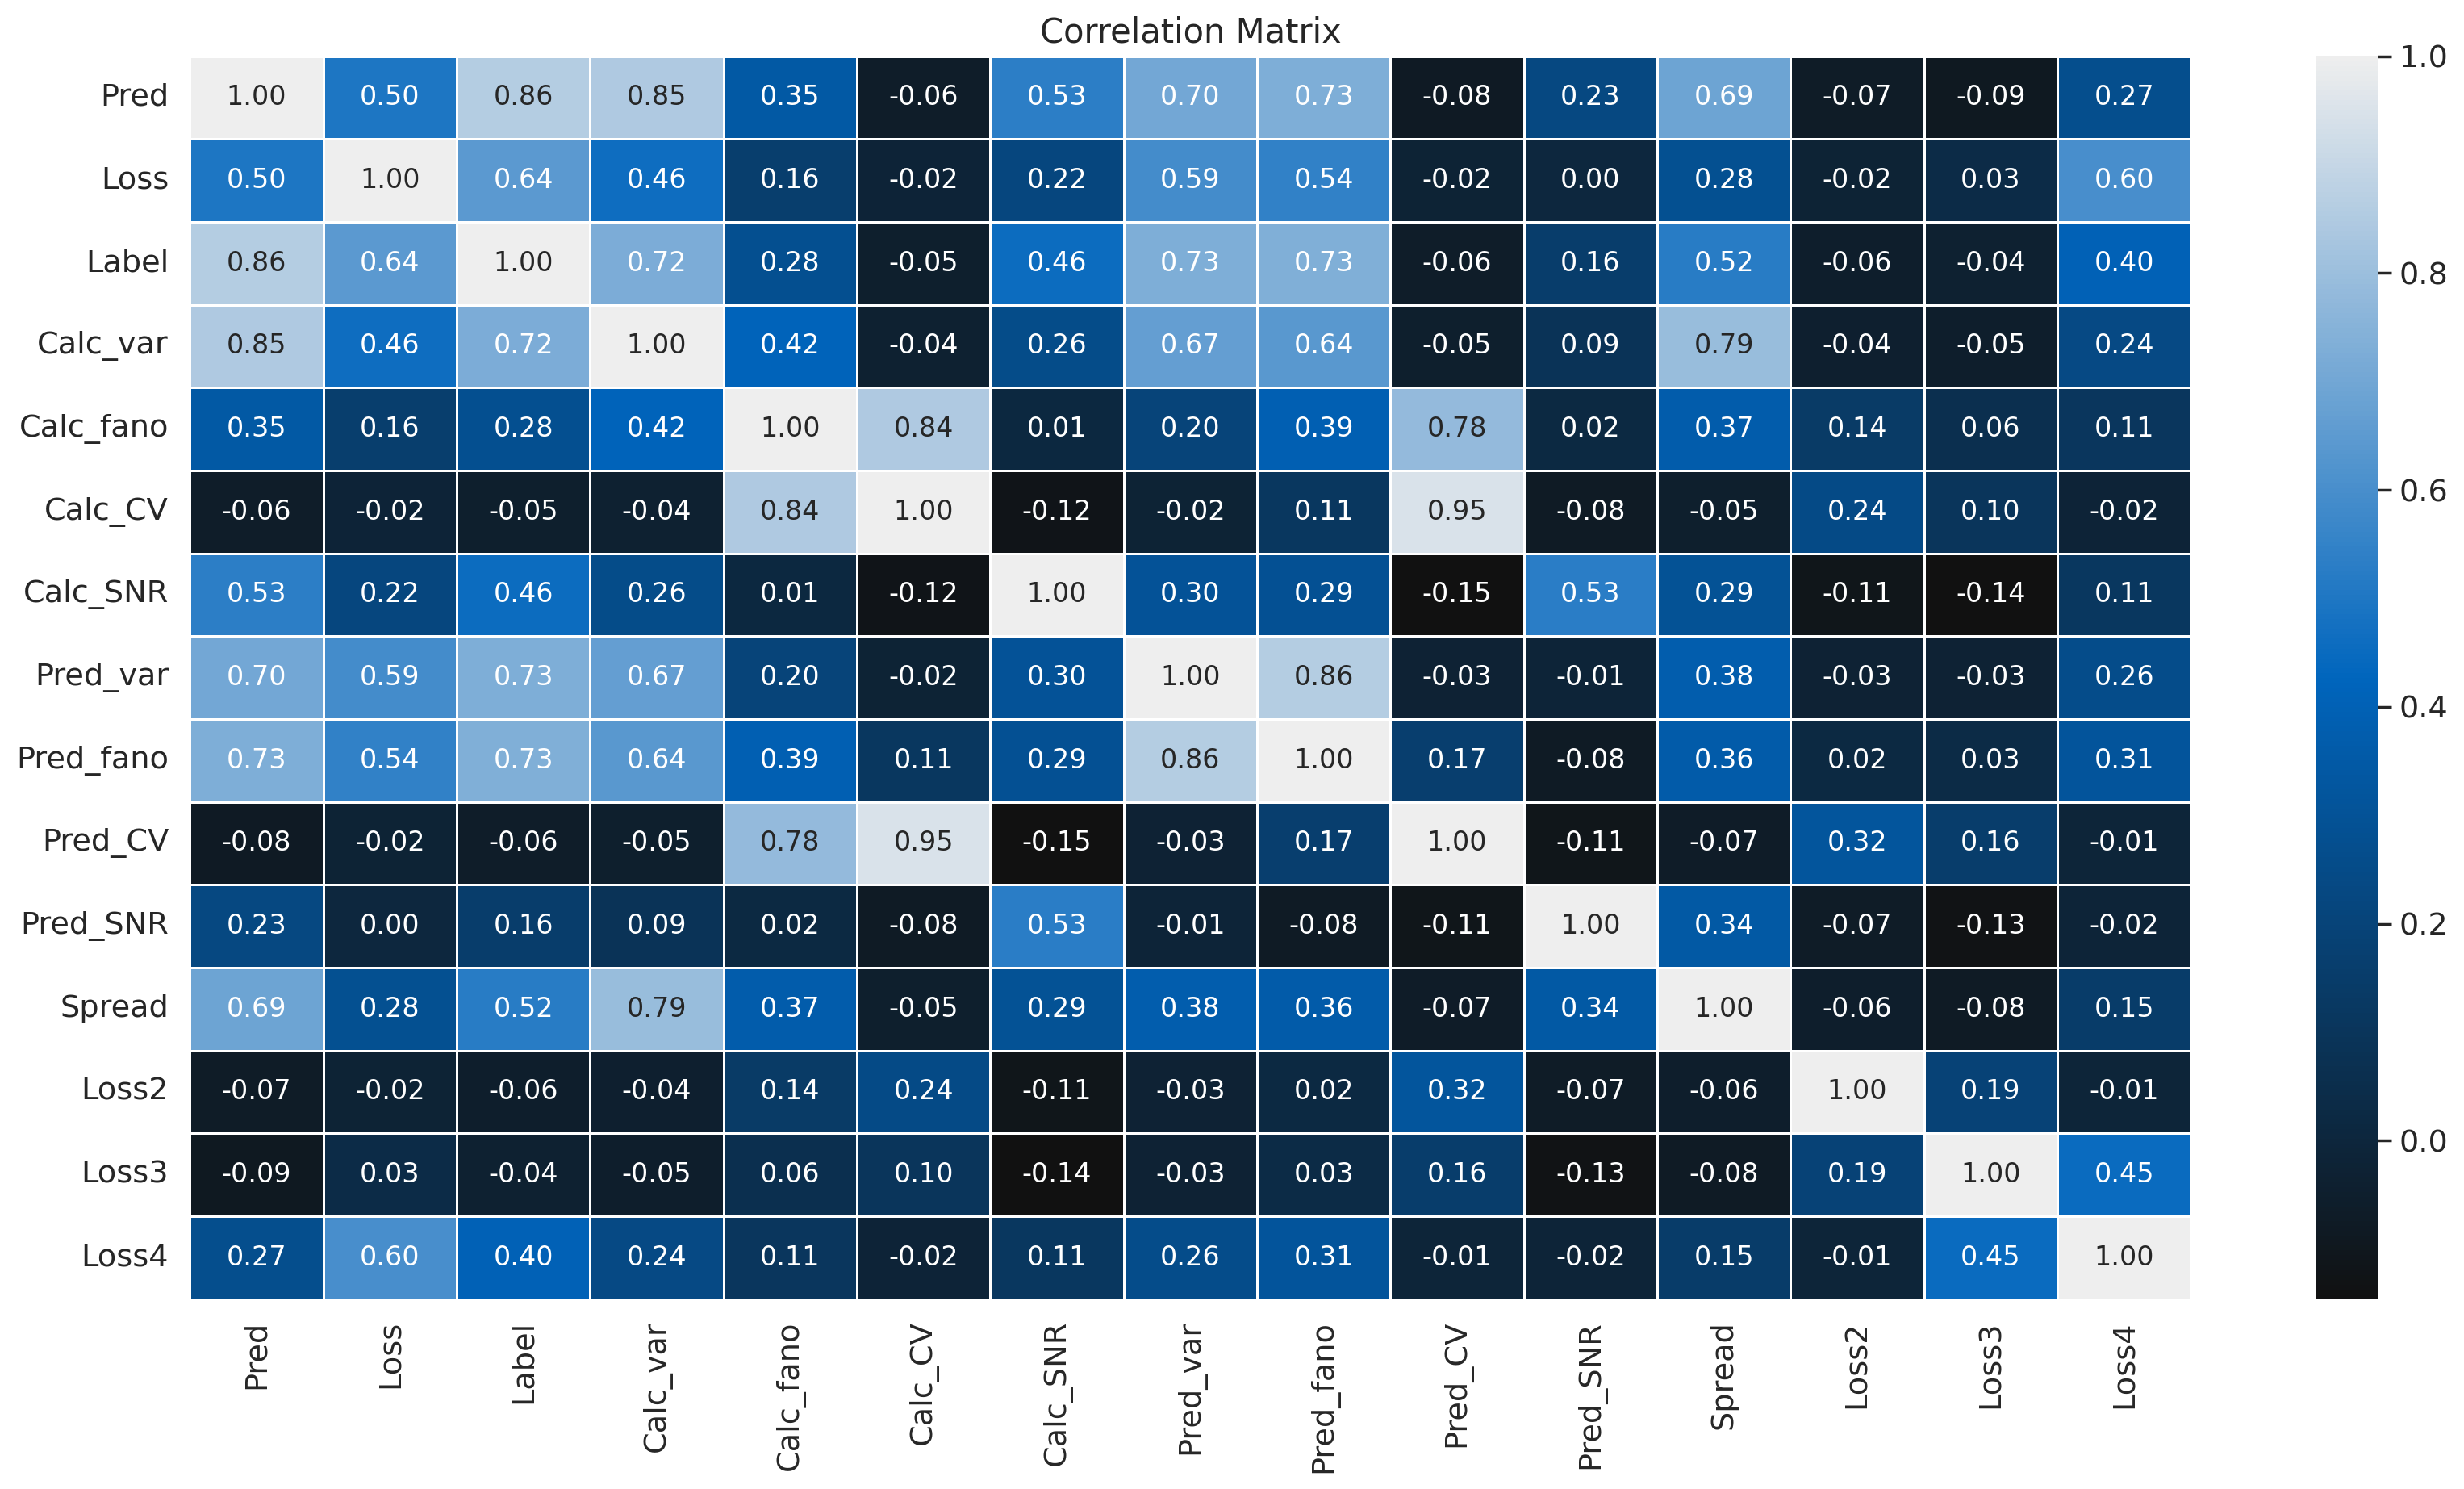

In [26]:
plt.figure(figsize=(20, 10))
# Generate a heatmap
sns.set(font_scale=1.25)

color1 = '#111111'  # Black
color2 = '#0065bd'  # Blue
color3 = '#eeeeee'  # White

# Create the colormap
my_colormap = LinearSegmentedColormap.from_list("my_colormap", [color1, color2, color3])

hm = sns.heatmap(corr_matrix, 
                 cbar=True, 
                 annot=True, 
                 fmt='.2f', 
                 annot_kws={'size': 12}, 
                 yticklabels=corr_matrix.columns, 
                 xticklabels=corr_matrix.columns, 
                 cmap=my_colormap,   # or any other colormap you prefer
                 linewidths=0.5)

plt.title('Correlation Matrix')
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintyCorrelationMatrix.png', format='png', dpi=200)
plt.show()

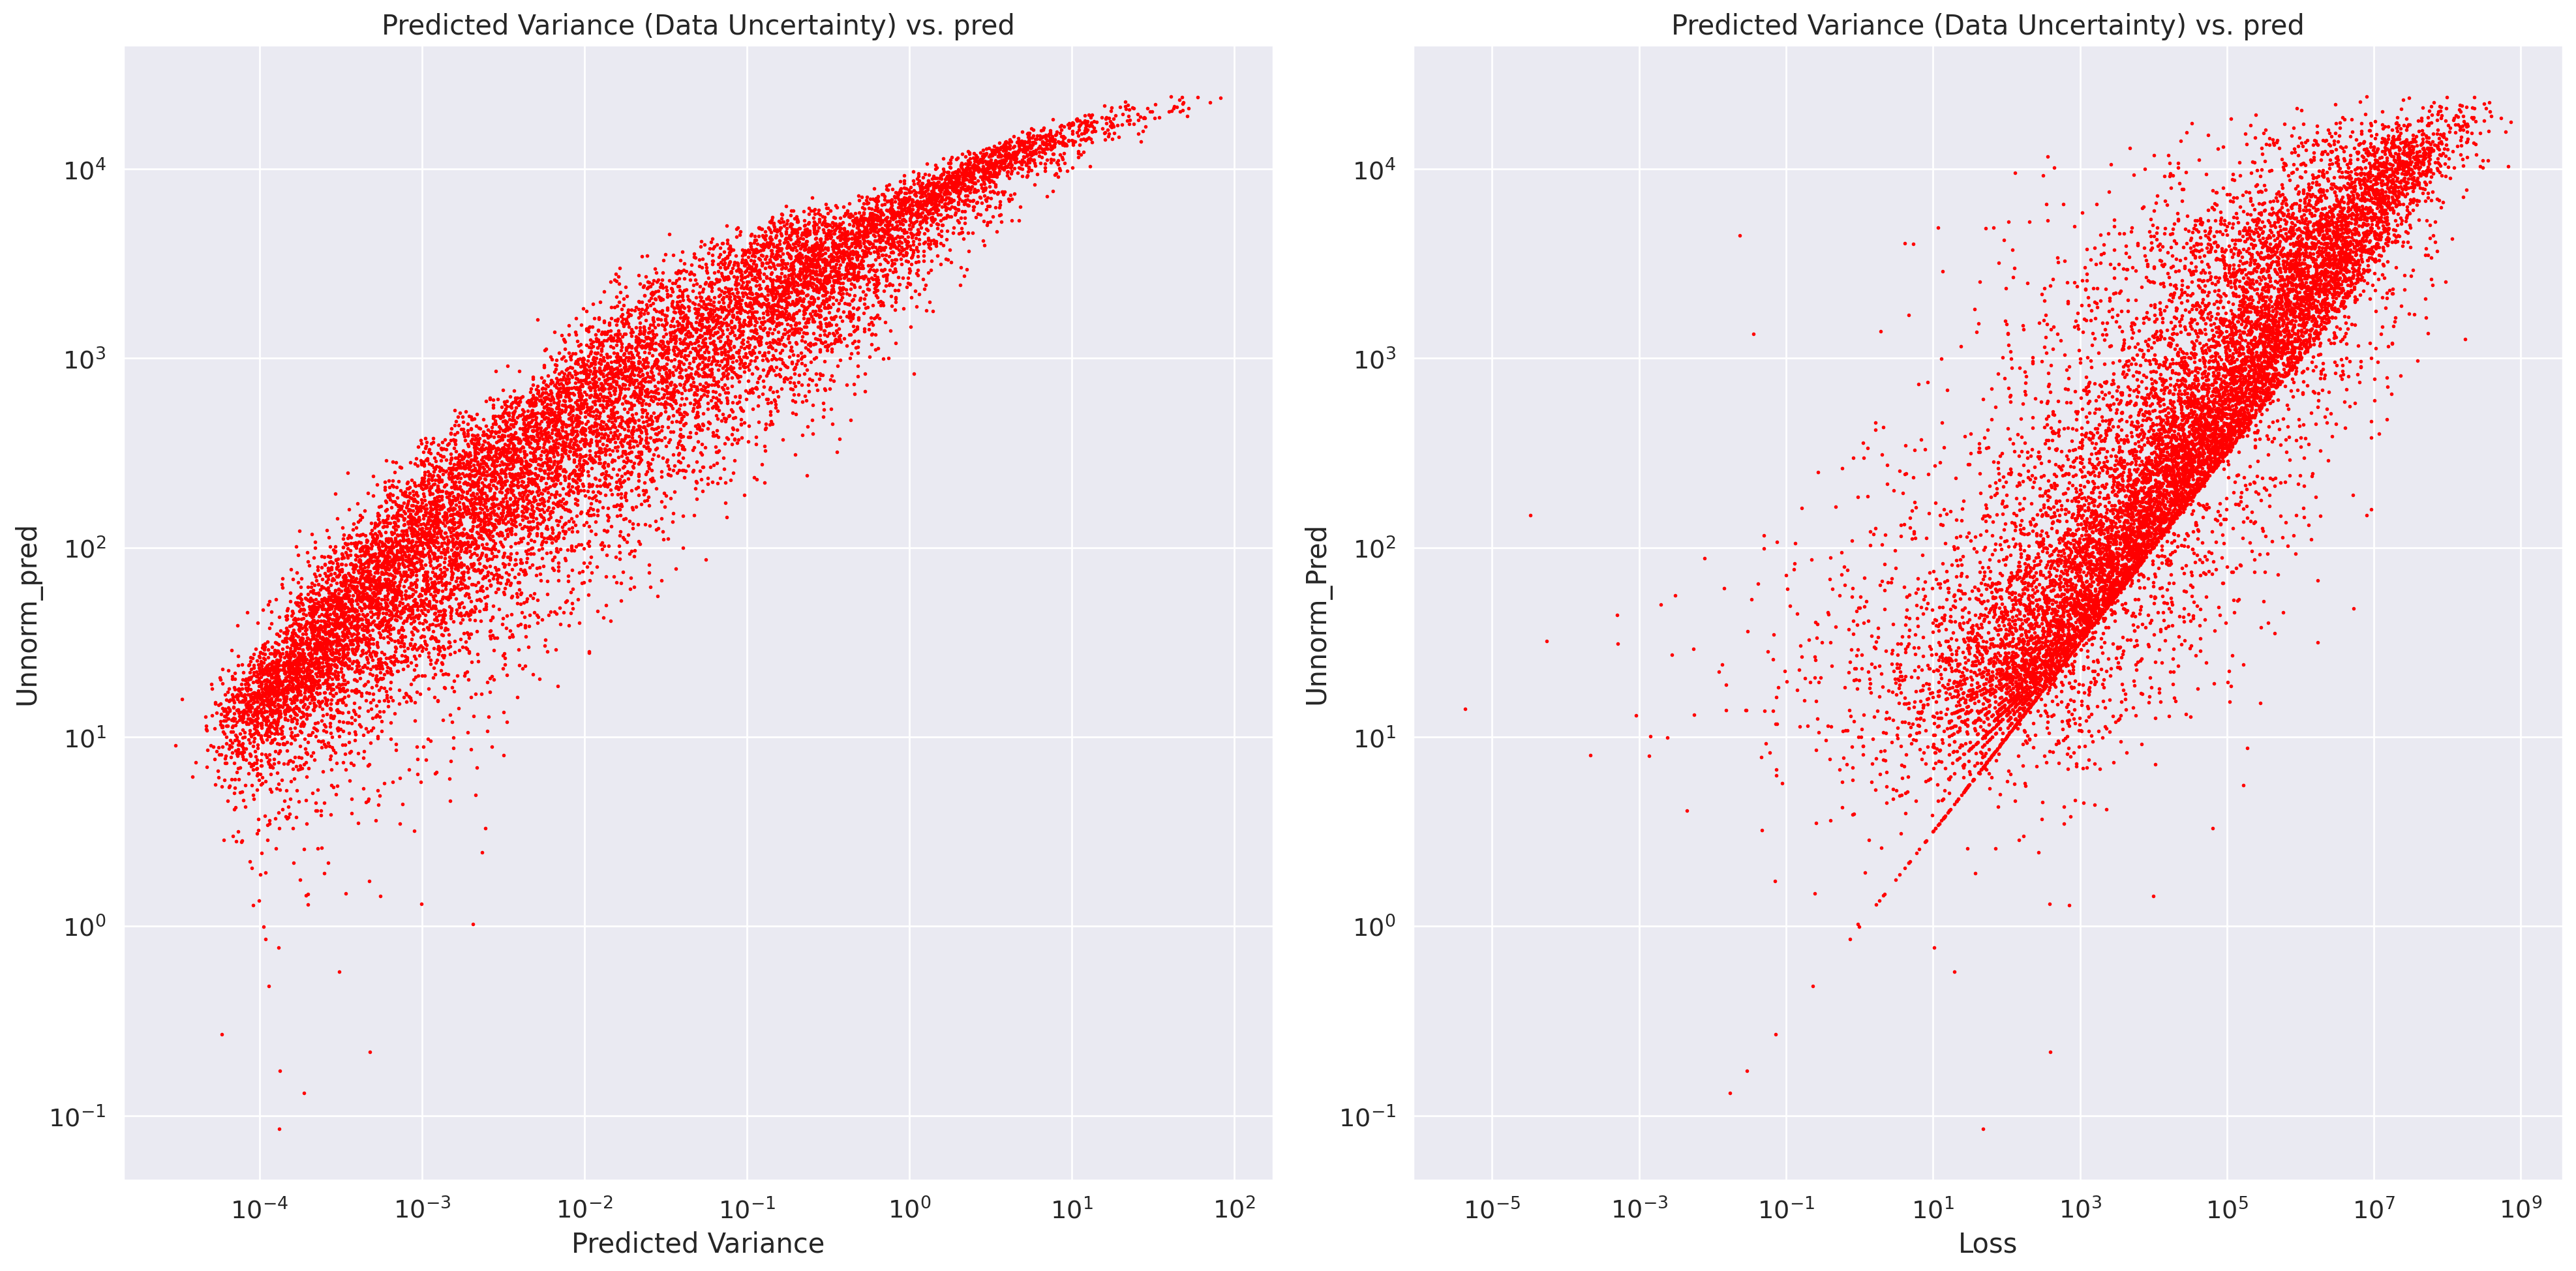

In [27]:
s=1
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, 2nd plot
ax1.scatter(pred_var, pred, color='red', s=s)
ax1.set_title(f"Predicted Variance (Data Uncertainty) vs. pred")
ax1.set_xlabel("Predicted Variance")
ax1.set_ylabel("Unnorm_pred")
#ax1.set_xlim(-6, 1)  # Set x-axis range from -6 to 1
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(loss, pred, color='red', s=s)
ax2.set_title(f"Predicted Variance (Data Uncertainty) vs. pred")
ax2.set_xlabel("Loss")
ax2.set_ylabel("Unnorm_Pred")
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()


In [28]:
loss_plot = loss
#y_axis = 'loss' / 'label' / 'pred'
y_axis = 'loss'

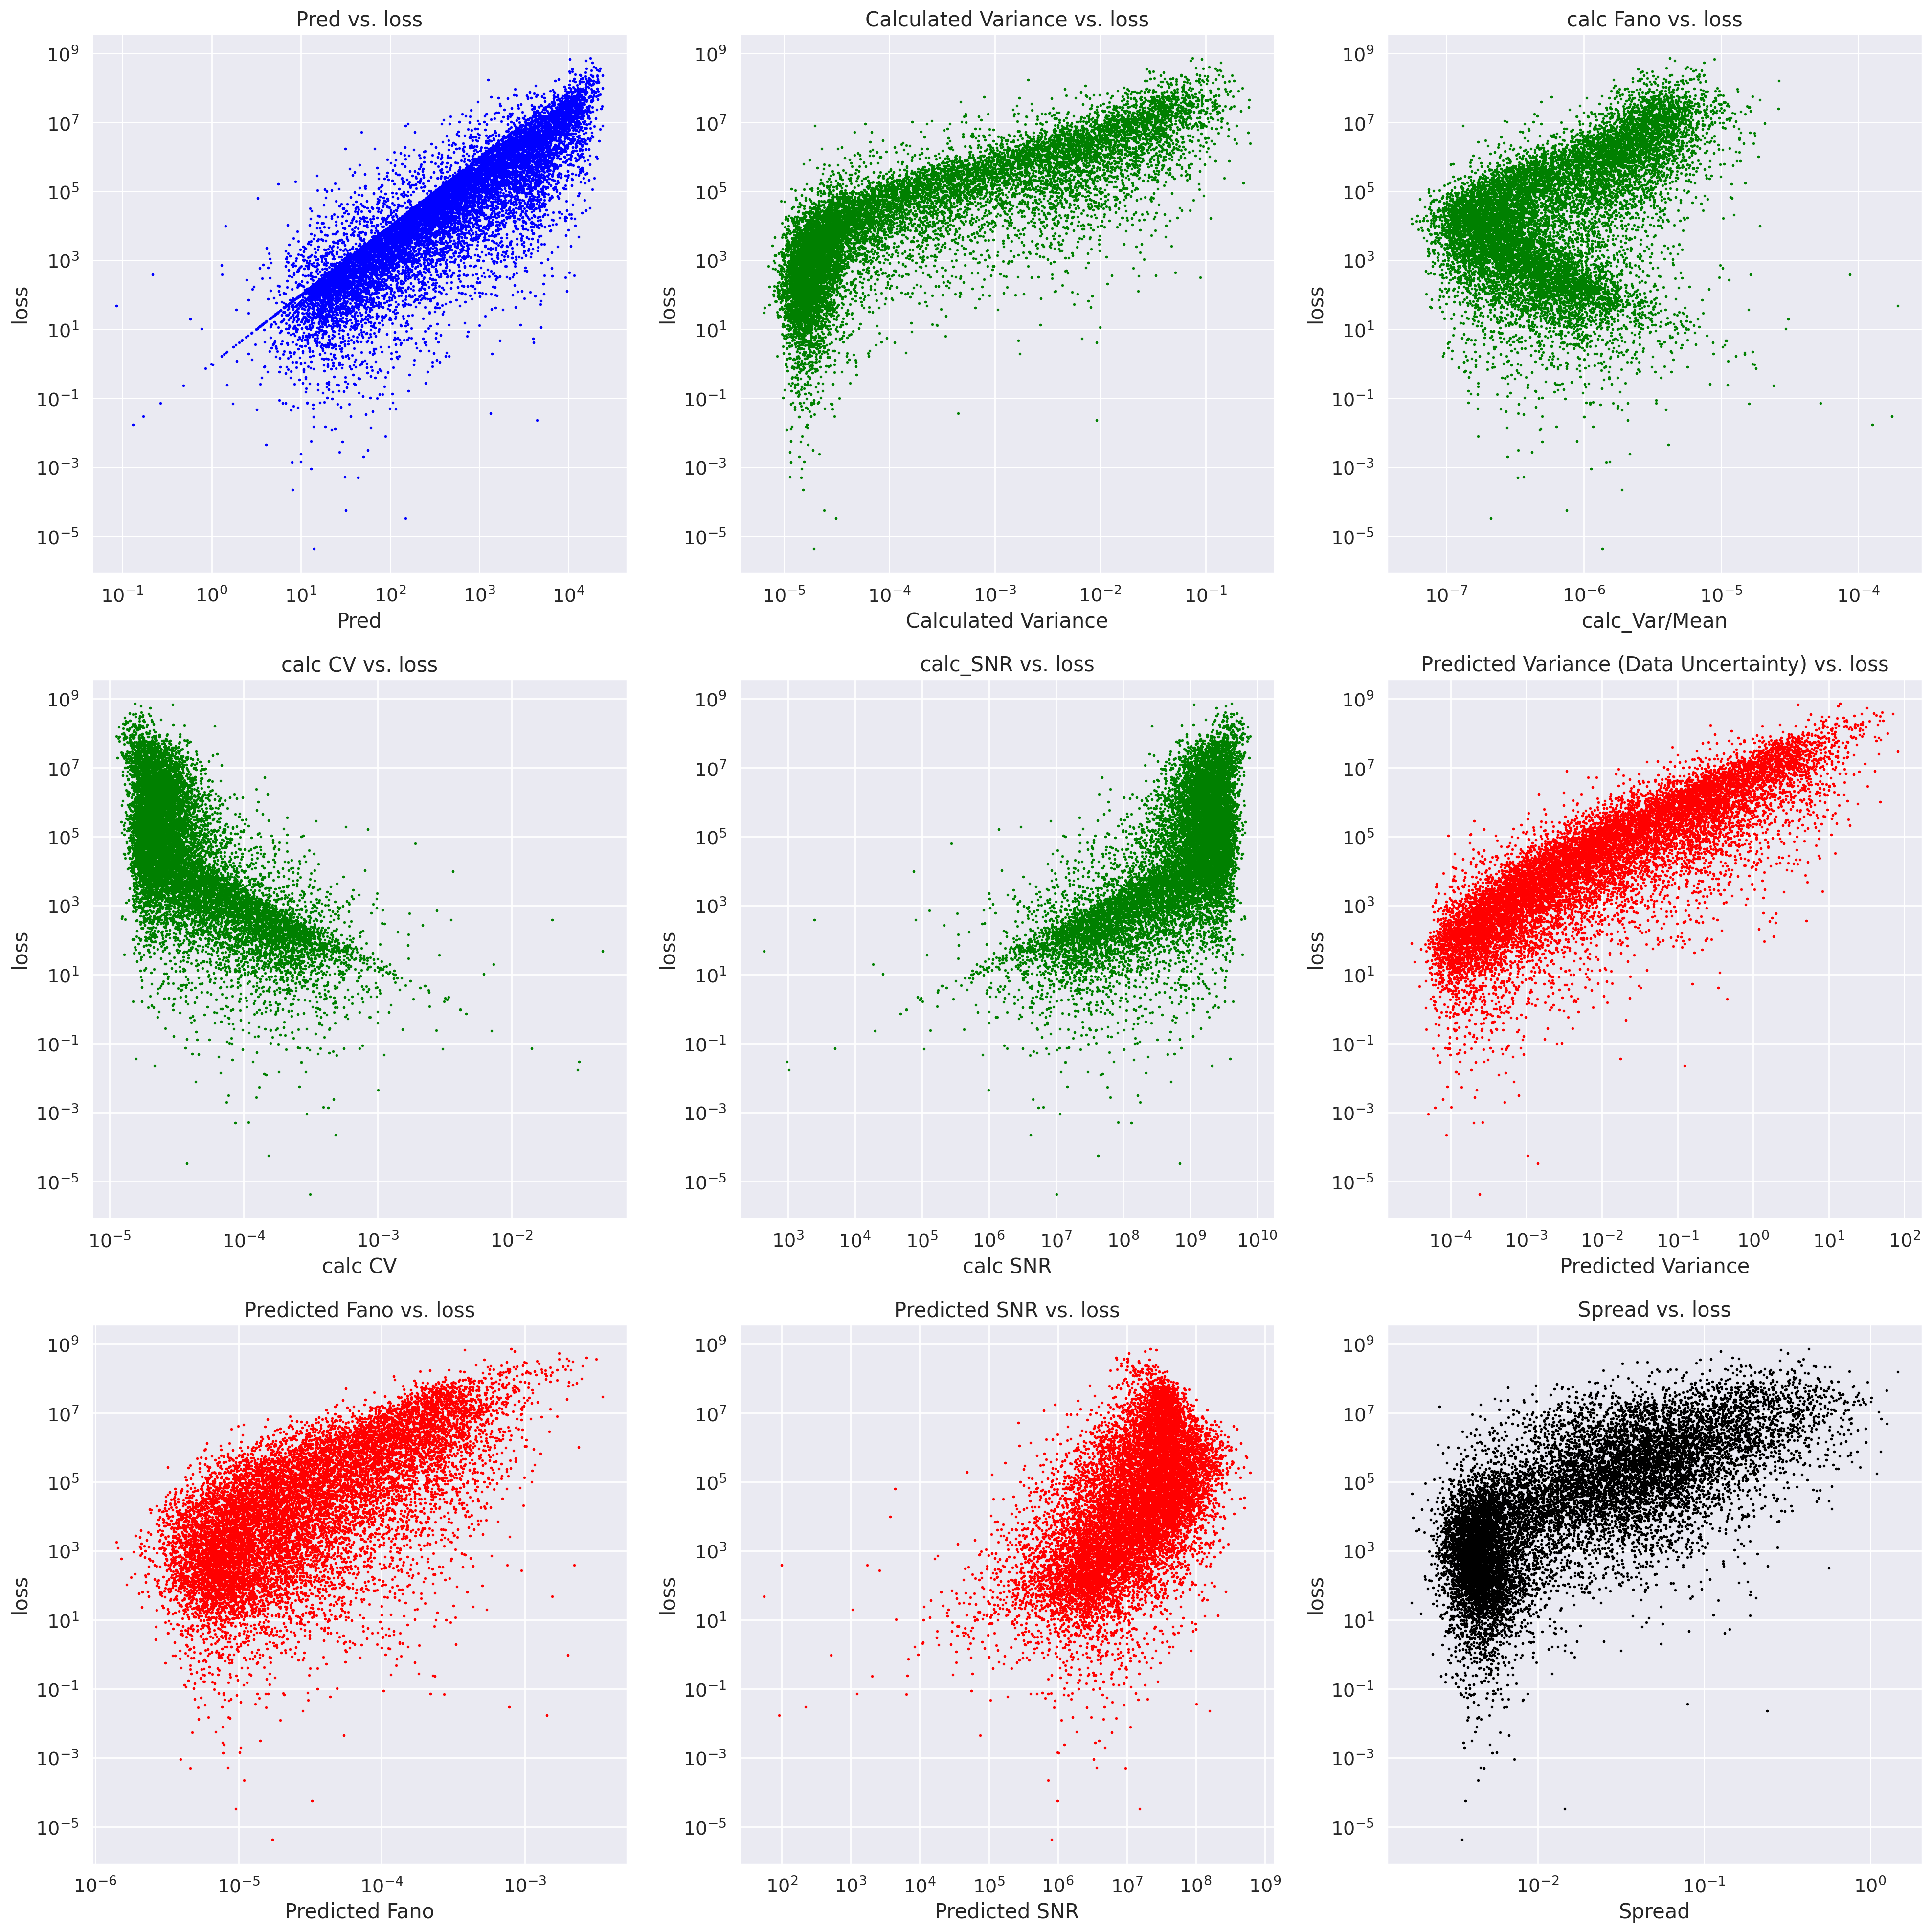

In [29]:
s = 1

# Plot for mean vs. loss
plt.figure(figsize=(20, 20))
ax1 = plt.subplot(3, 3, 1)  # 1 row, 2 columns, 1st plot
ax1.scatter(pred, loss_plot, color='blue', s=s)
ax1.set_title(f"Pred vs. {y_axis}")
ax1.set_xlabel("Pred")
ax1.set_ylabel(y_axis)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Plot for var vs. loss
ax2 = plt.subplot(3, 3, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_var, loss_plot, color='green', s=s)
ax2.set_title(f"Calculated Variance vs. {y_axis}")
ax2.set_xlabel("Calculated Variance")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 3)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_fano, loss_plot, color='green', s=s)
ax2.set_title(f"calc Fano vs. {y_axis}")
ax2.set_xlabel("calc_Var/Mean")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 4)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_CV, loss_plot, color='green', s=s)
ax2.set_title(f"calc CV vs. {y_axis}")
ax2.set_xlabel("calc CV")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 5)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_SNR, loss_plot, color='green', s=s)
ax2.set_title(f"calc_SNR vs. {y_axis}")
ax2.set_xlabel("calc SNR")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 6)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_var, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted Variance (Data Uncertainty) vs. {y_axis}")
ax2.set_xlabel("Predicted Variance")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 7)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_fano, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted Fano vs. {y_axis}")
ax2.set_xlabel("Predicted Fano")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 8)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_SNR, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted SNR vs. {y_axis}")
ax2.set_xlabel("Predicted SNR")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 9)  # 1 row, 2 columns, 2nd plot
ax2.scatter(spread, loss_plot, color='black', s=s)
ax2.set_title(f"Spread vs. {y_axis}")
ax2.set_xlabel("Spread")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintiesVsLoss.png', format='png', dpi=200)

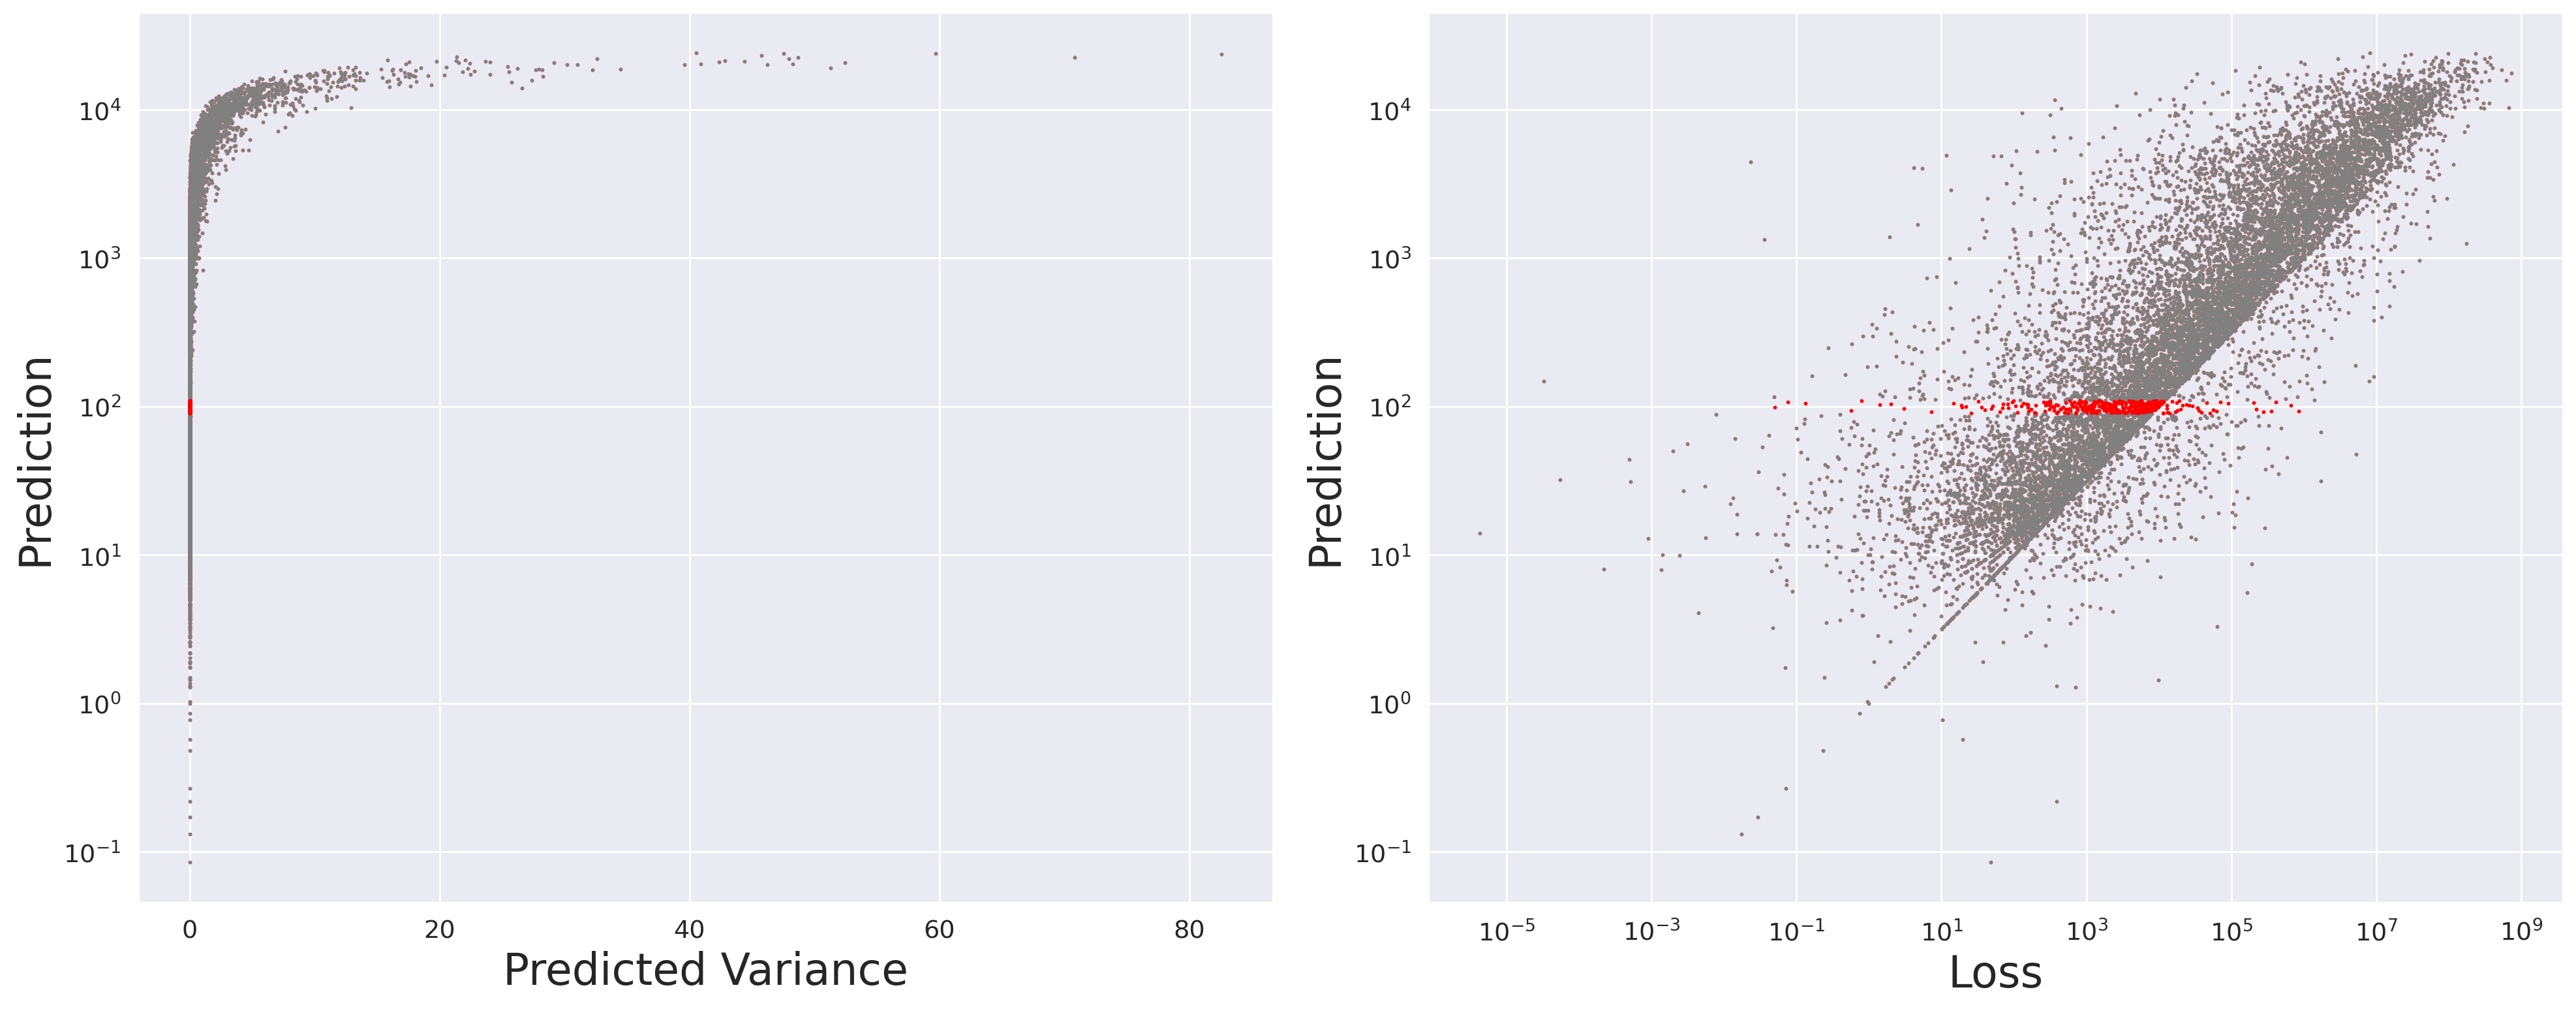

In [30]:
plt.figure(figsize=(20, 8))

c = 100
w = 10

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(pred_var, pred, color='red', s=s)
ax2.scatter(pred_var[(pred < c-w) | (pred > c+w)], pred[(pred < c-w) | (pred > c+w)], color='grey', s=s)
ax2.scatter(pred_var[(pred >= c-w) & (pred <= c+w)], pred[(pred >= c-w) & (pred <= c+w)], color='red', s=s)

#x = np.linspace(17, 6000, num=1000)
#coef = np.polyfit(pred_var, pred, 8)
#fit_line = np.polyval(coef, x)
#ax2.plot(x, fit_line, color='blue', linewidth=3, label='implicit Boundary')
#ax2.legend(loc='upper right')

#x = np.logspace(1, 4, num=1000)
#params, covariance = curve_fit(power_law, pred_var, pred)
#a, b = params
#a = 0.39
#b = 1.31
#fit_line = power_law(x, a, b)
#ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
#ax2.legend(loc='upper right')

ax2.set_xlabel("Predicted Variance", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
#ax2.set_xscale('log')
ax2.set_yscale('log')


ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(loss, pred, color='red', s=s)
ax2.scatter(loss[(pred < c-w) | (pred > c+w)], pred[(pred < c-w) | (pred > c+w)], color='grey', s=s)
ax2.scatter(loss[(pred >= c-w) & (pred <= c+w)], pred[(pred >= c-w) & (pred <= c+w)], color='red', s=s)

#x = np.linspace(0, 10_000_000, num=1000)
#coef = np.polyfit(loss, pred, 1)
#fit_line = np.polyval(coef, x)
#ax2.plot(x, fit_line, color='blue', linewidth=3, label='implicit Boundary')
#ax2.legend(loc='upper right')

#x = np.logspace(0, 8, num=1000)
#params, covariance = curve_fit(power_law, loss, pred)
#a, b = params
#a = 1.52
#b = 0.62
#fit_line = power_law(x, a, b)
#ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
#ax2.legend(loc='upper right')

ax2.set_xlabel("Loss", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintyBins.png', format='png', dpi=200)

In [31]:
from scipy.optimize import curve_fit
# Define the power-law function

def power_law(x, a, b):
    return a * x**(b)

def fit_power_law(x_values, y_values, q=0.5, range_start=1, range_end=4):
    # Add a constant to the predictor variable for the intercept term
    x_values_log = sm.add_constant(np.log10(x_values))
    y_values_log = np.log10(y_values + 1e-2)
    # Fit a quantile regression model with a quantile value of 0.5 (median)
    model = sm.QuantReg(y_values_log, x_values_log)
    result = model.fit(q=q)
    # Get the fitted parameters
    intercept, slope = result.params
    # Convert parameters back to original space
    a = 10**intercept
    b = slope
    # Generate values for the fitted power-law curve
    x = np.logspace(range_start, range_end, num=1000)
    fit_line = (power_law(x, a, b))
    ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
    return a, b


#def power_law(x, a, b):
#    return a * np.emath.logn(b, x)
def log_law(x, a, b):
    return a + b * np.log10(x)

def fit_log_law(x_values, y_values, q=0.5, range_start=1, range_end=4):
    # Add a constant to the predictor variable for the intercept term
    x_values_log = sm.add_constant(np.log10(x_values))
    y_values_log = np.log10(y_values + 1e-2)
    # Fit a quantile regression model with a quantile value of 0.5 (median)
    model = sm.QuantReg(y_values_log, x_values_log)
    result = model.fit(q=q)
    # Get the fitted parameters
    intercept, slope = result.params
    # Convert parameters back to original space
    a = 10**intercept
    b = slope
    # Generate values for the fitted logarithmic-law curve
    x = np.logspace(range_start, range_end, num=1000)
    fit_line = log_law(x, a, b)
    plt.plot(x, fit_line, label=f'Logarithmic Fit: $y = {a:.2f} + {b:.2f} \cdot \\log(x)$', color='blue', linewidth=3)
    return a, b

def exponential_decay_law(x, a, b):
    return a * np.exp(-b * x)

def fit_exponential_decay_law(x_values, y_values, q=0.5, range_start=-6, range_end=1):
    # Add a constant to the predictor variable for the intercept term
    x_values_log = sm.add_constant(x_values)
    y_values_log = np.log(y_values + 1e-2)
    # Fit a quantile regression model with a quantile value of 0.5 (median)
    model = sm.QuantReg(y_values_log, x_values_log)
    result = model.fit(q=q)
    # Get the fitted parameters
    intercept, slope = result.params
    # Convert parameters back to original space
    a = np.exp(intercept)
    b = -slope
    # Generate values for the fitted exponential decay curve
    x = np.linspace(range_start, range_end, num=1000)
    fit_line = exponential_decay_law(x, a, b)
    plt.plot(x, fit_line, label=f'Exponential Decay Fit: $y = {a:.2f} \cdot e^{{-{b:.2f}x}}$', color='blue', linewidth=3)
    return a, b

def exp_law(x, a, b):
    return a * np.exp(b * x)

def fit_exp_law(x_values, y_values, q=0.5, range_start=1, range_end=4):
    # Add a constant to the predictor variable for the intercept term
    x_values_exp = sm.add_constant(x_values)
    y_values_log = np.log(y_values + 1e-2)
    
    # Fit a quantile regression model with a quantile value of 0.5 (median)
    model = sm.QuantReg(y_values_log, x_values_exp)
    result = model.fit(q=q)
    
    # Get the fitted parameters
    intercept, slope = result.params
    # Convert parameters back to original space
    a = np.exp(intercept)
    b = slope
    # Generate values for the fitted exponential curve
    x = np.linspace(range_start, range_end, num=1000)
    fit_line = exp_law(x, a, b)
    plt.plot(x, fit_line, label=f'Exponential Fit: $y = {a:.2f} \cdot e^{{{b:.2f}x}}$', color='blue', linewidth=3)
    return a, b

def linear_law(x, a, b):
    return b * x + a

def fit_linear_law(x_values, y_values, q=0.5, range_start=1, range_end=4, a_i=30000, b_i=20000):
    # Add a constant to the predictor variable for the intercept term
    x_values = sm.add_constant(x_values)
    # Fit a quantile regression model with a quantile value of 0.5 (median)
    model = sm.QuantReg(y_values, x_values)
    result = model.fit(q=q)
    # Get the fitted parameters
    intercept, slope = result.params
    # Convert parameters back to original space
    a = intercept
    b = slope
    a = a_i
    b = b_i
    # Generate values for the fitted power-law curve
    x = np.linspace(range_start, range_end, num=1000)
    fit_line = (linear_law(x, a, b))
    ax2.plot(x, fit_line, label=f'Linear Fit: $y = {b:.2f} \cdot x {a:.2f}$', color='blue', linewidth=3)
    return a, b

def poly_law(x, coef):
    return np.polyval(coef, x)

def fit_poly_law(x_values, y_values, range_start=0, range_end=7):
    coef = np.polyfit(x_values, y_values, 8)
    # Generate values for the fitted power-law curve
    x = np.logspace(range_start, range_end, num=1000)
    fit_line = poly_law(x, coef)
    ax2.plot(x, fit_line, label=f'Poly Fit', color='blue', linewidth=3)
    return coef


def plot_stuff(x_label='Predicted Variance', y_label='Prediction', x_log=True, y_log=True):
    ax2.legend(loc='upper left')
    ax2.set_xlabel(f'{x_label}', fontsize=24)
    ax2.set_ylabel(f'{y_label}', fontsize=24)
    if x_log:
        ax2.set_xscale('log')
    if y_log:
        ax2.set_yscale('log')

In [32]:
def fit_lowess(x_values, y_values, frac=0.001, delta=0.01):
    lowess = sm.nonparametric.lowess(y_values, x_values, frac=frac, is_sorted=False, delta=delta)
    #lowess = sm.nonparametric.lowess(x_values, y_values, frac=frac, is_sorted=False, delta=delta)
    interp_function = interp1d(lowess[:, 0], lowess[:, 1], kind='linear', fill_value='extrapolate')
    
    #x = np.linspace(min(lowess[:, 0]), max(lowess[:, 0]), 1000)
    x = np.logspace(-6, 1.6, 1000)
    fit_line = interp_function(x)
    ax2.plot(x, fit_line, label=f'Lowess Fit', color='blue', linewidth=3)
    return interp_function

In [36]:
def linear_interp1d(x, y):
    """
    Creates a linear interpolation function based on the given x and y arrays.
    Returns a function that interpolates y values for new x values.
    """
    
    def interpolator(x_new):
        """
        Interpolates the y values for new x values using linear interpolation.
        """
        x_new = np.asarray(x_new)  # Ensure x_new is a NumPy array

        # Find indices of the closest points to the right of the new x values
        idx = np.searchsorted(x, x_new, side='left')
        idx = np.clip(idx, 1, len(x)-1)

        x_left, x_right = x[idx-1], x[idx]
        y_left, y_right = y[idx-1], y[idx]

        # Calculate the slope of each segment
        slope = (y_right - y_left) / (x_right - x_left)

        # Linear interpolation formula
        y_new = y_left + (x_new - x_left) * slope
        return y_new
    
    return interpolator

In [94]:
def fit_median_line(x_values, y_values, window=2000, percentile=50, smoothing=2, range_start=-6, range_end=4):
    #x_values = np.append(0, x_values)
    #y_values = np.append(0, y_values)
    y_values, indices = np.unique(y_values, return_index=True)
    x_values = x_values[indices]

    median_x_values =[]
    for i in range(len(y_values)):
        window_below = i - window//2
        window_above = i + window//2
        if window_below < 0:
            #window_above -= window_below
            window_above = i + 1
            window_below = 0
        elif window_above > len(y_values):
            #window_below -= (window_above - len(y_values))
            window_below = i - 1
            window_above = len(y_values)
        data_in_window = x_values[window_below:window_above]
        #median_x = np.median(data_in_window)
        median_x = np.percentile(data_in_window, percentile)
        median_x_values.append(median_x)


    # Keep only the first occurrence of each unique value in median_x_values
    median_x_values = np.array(median_x_values)
    median_x_values, unique_indices = np.unique(median_x_values, return_index=True)
    y_values = y_values[unique_indices]

    max_y = 0
    indices_to_drop = []
    for i in range(len(y_values)):
        if y_values[i] <= max_y:
            indices_to_drop.append(i)
        else:
            max_y = y_values[i]
    median_x_values = np.delete(median_x_values, indices_to_drop)[::smoothing]
    y_values = np.delete(y_values, indices_to_drop)[::smoothing]

    median_x_values = np.append(median_x_values[0]/1.1, median_x_values)
    y_values = np.append(0, y_values)

    median_x_values = np.append(median_x_values, median_x_values[-1] * 1.1)
    y_values = np.append(y_values, max_y * 2)
    
    #interp_function = interp1d(median_x_values, median_y_values, kind='linear', fill_value='extrapolate')
    #spl = CubicSpline(median_x_values, y_values, bc_type='natural')
    #spl = Akima1DInterpolator(median_x_values, y_values)
    #spl = PchipInterpolator(median_x_values, y_values, extrapolate=True)
    spl = linear_interp1d(median_x_values, y_values)
    
    x = np.logspace(range_start, range_end, 2000)
    #x = np.linspace(-15, 5, 1000)
    fit_line = spl(x)
    ax2.plot(x, fit_line, label=f'Median Line Fit', color='blue', linewidth=3)
    return spl

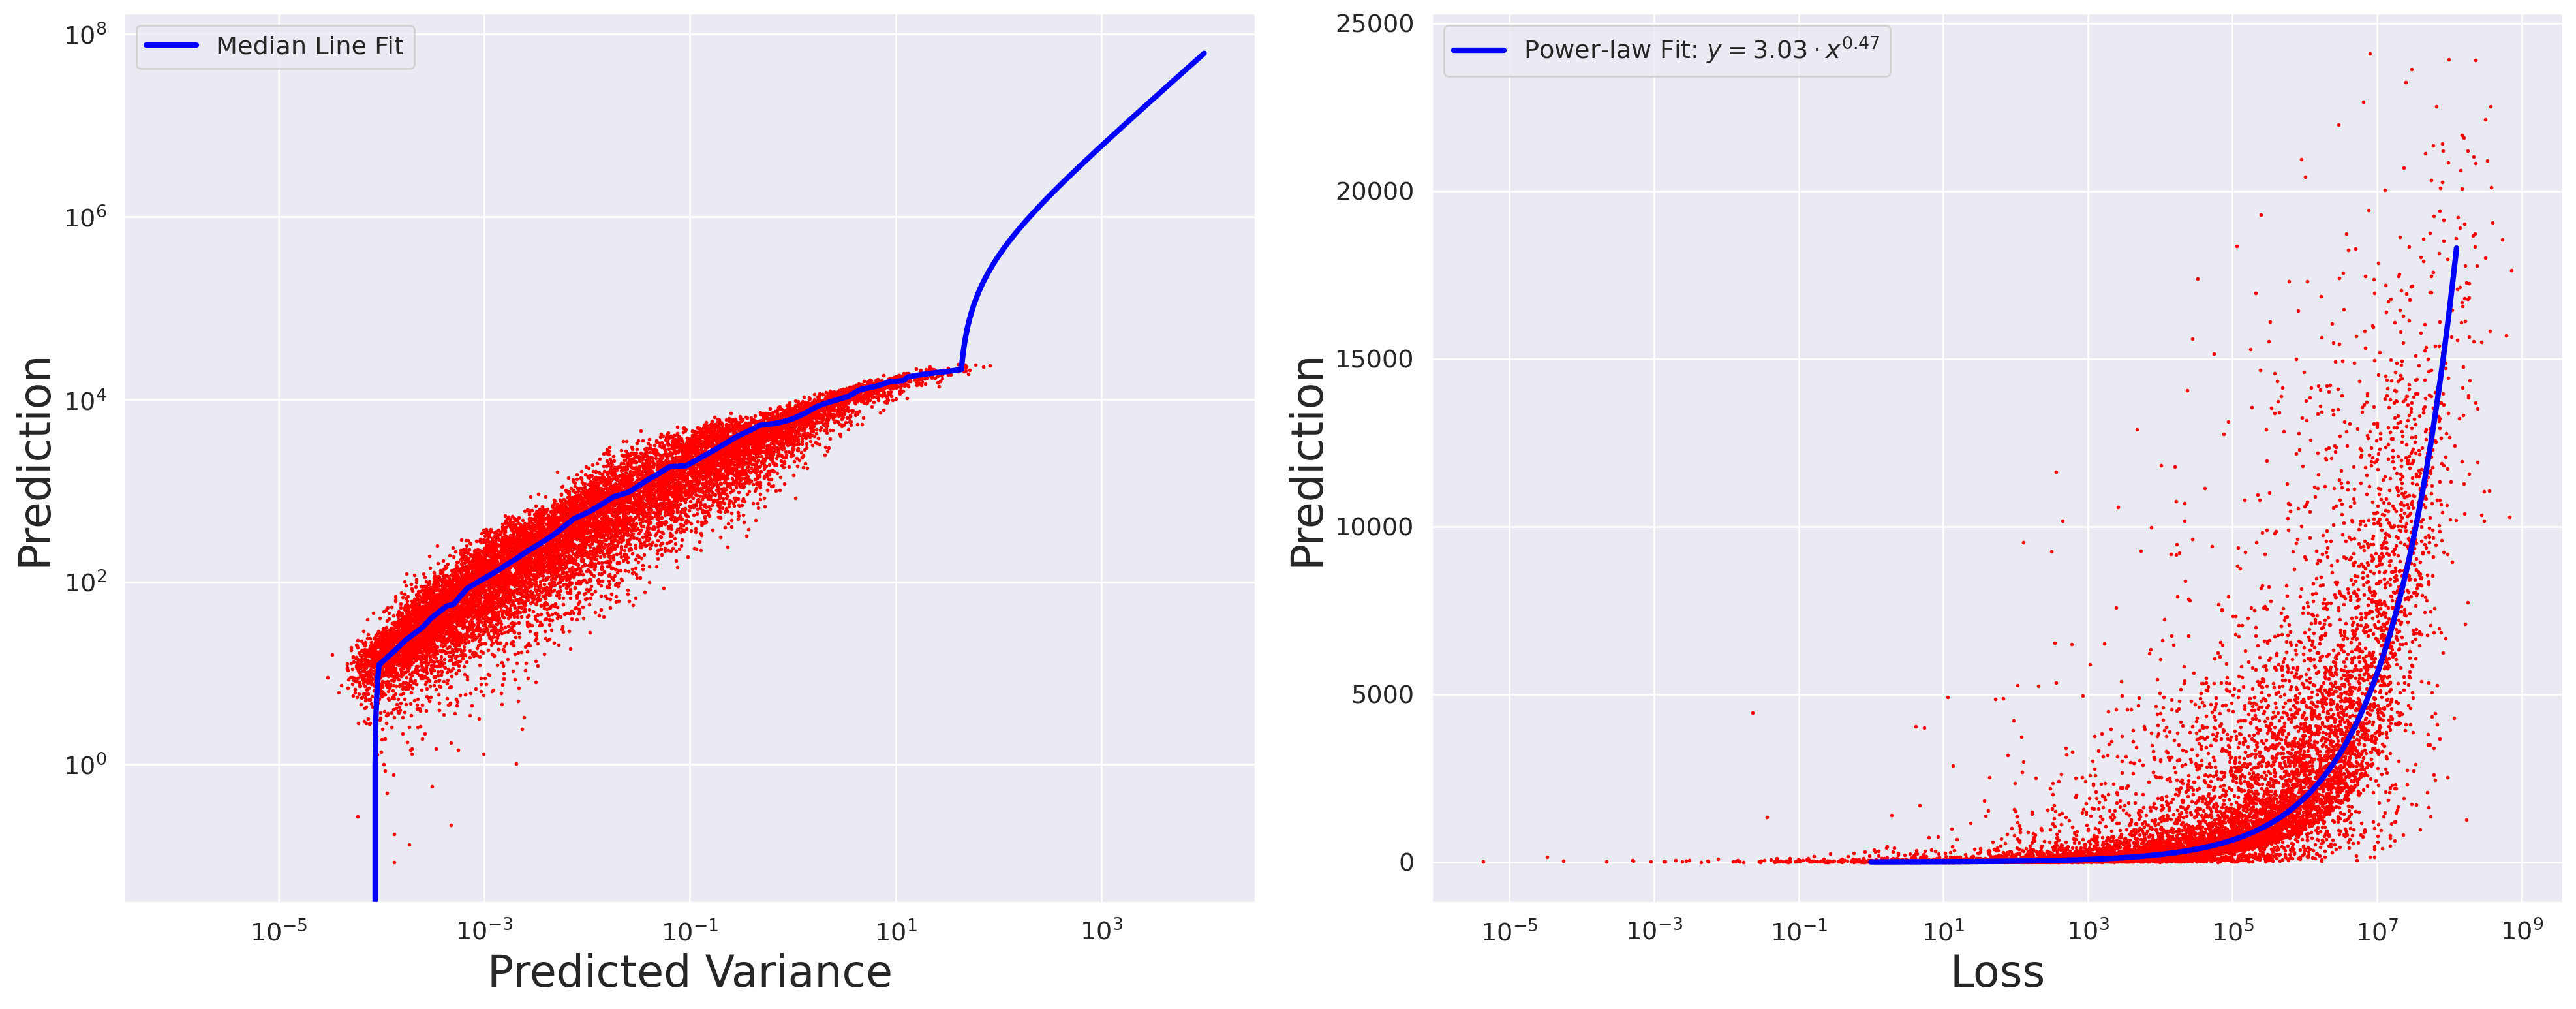

In [95]:
x_values = pred_var

# QUANTILE REGRESSION
plt.figure(figsize=(20, 8))
ax2 = plt.subplot(1, 2, 1)

ax2.scatter(x_values, pred, color='red', s=s)
#fit_power_law(x_values, pred, range_start=-6, range_end=1)
#fit_linear_law(x_values, pred, q=0.7, range_start=-6, range_end=0)
#fit_poly_law(x_values, pred, range_start=0, range_end=7)
#fit_log_law(x_values, pred)
#fit_exponential_decay_law(x_values, pred)
#fit_exp_law(x_values, pred, range_start=0, range_end=17)
#fit_lowess(x_values, pred)
fit_median_line(x_values, pred, window=50, percentile=50, smoothing=10)

plot_stuff(x_log=True, y_log=True)

################################

ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(loss, pred, color='red', s=s)
fit_power_law(loss, pred, range_start=0, range_end=8.1)
#fit_exp_law(loss, pred, range_start=0, range_end=1e5)

plot_stuff(x_label='Loss', y_label='Prediction', x_log=True, y_log=False)

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintyFitPowerlawLog.png', format='png', dpi=200)

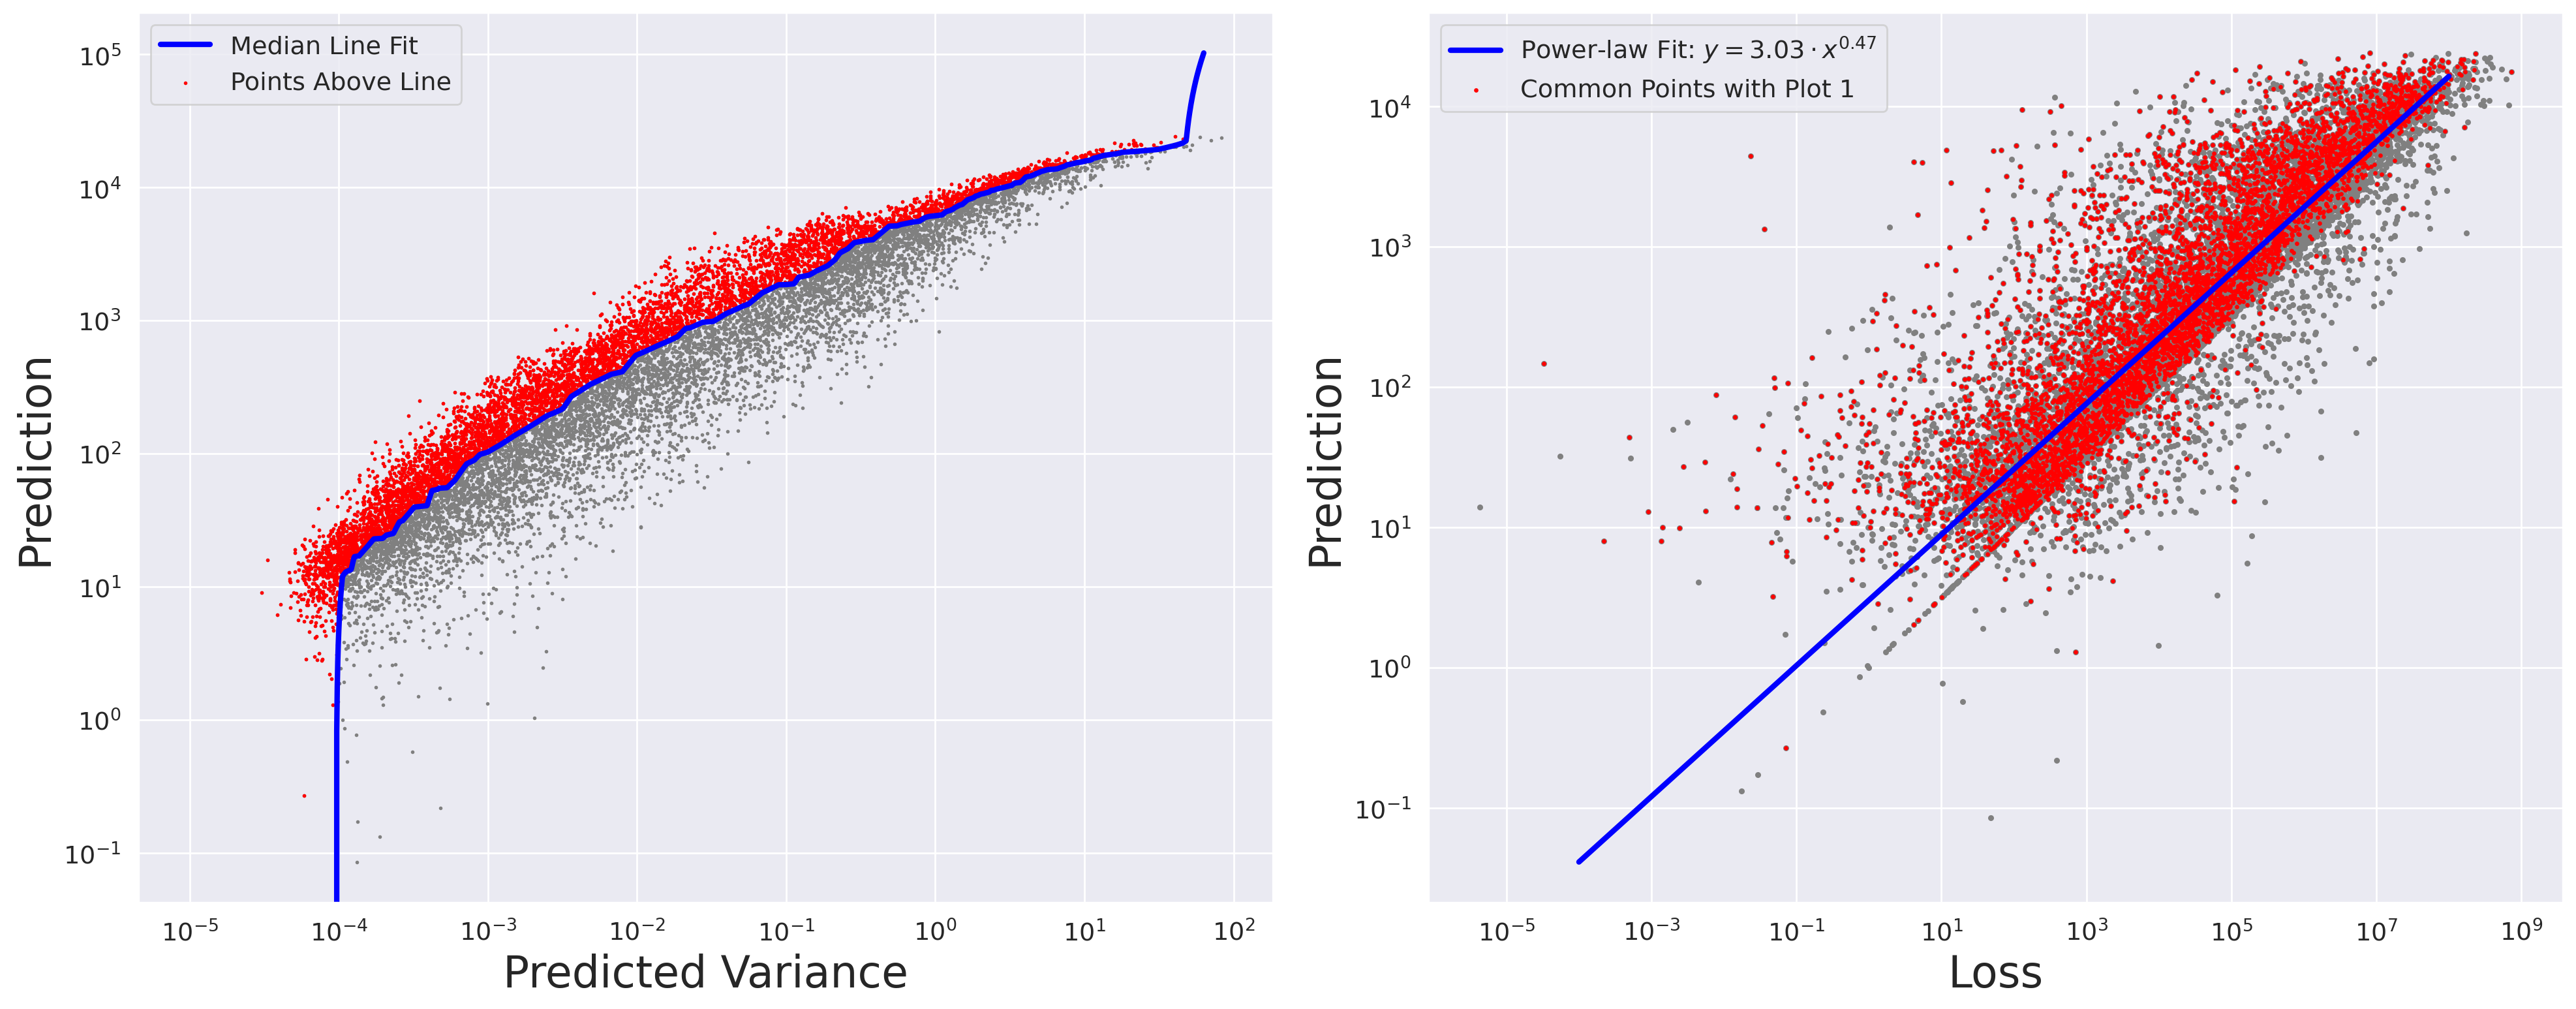

In [118]:
x_values =  pred_var

plt.figure(figsize=(20, 8))

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(x_values, pred, color='grey', s=s)  # Default color is grey for all points
# Identify points above the line and color them red

#a1, b1 = fit_power_law(x_values, pred, q=0.5, range_start=-5.5, range_end=-1)
#above_line1 = pred > power_law(x_values, a1, b1)

#a1, b1 = fit_linear_law(x_values, pred, q=0.7, range_start=-4, range_end=0, a_i=50_000, b_i=10000)
#above_line1 = pred > linear_law(x_values, a1, b1)

#coef = fit_poly_law(x_values, pred, range_start=-1, range_end=0)
#above_line1 = pred > poly_law(x_values, coef)

#a1, b1 = fit_exponential_decay_law(x_values, pred, q=0.9)
#above_line1 = pred > exponential_decay_law(x_values, a1, b1)

#a1, b1 = fit_exp_law(x_values, pred, range_start=0, range_end=17)
#above_line1 = pred > exp_law(x_values, a1, b1)

#interp_function = fit_lowess(x_values, pred, frac=0.01, delta=0.00001)
#above_line1 = pred > interp_function(x_values)

interp_function = fit_median_line(x_values, pred, window=100, percentile=50, smoothing=5, range_start=-5, range_end=1.8)
above_line1 = pred > interp_function(x_values)


ax2.scatter(x_values[above_line1], pred[above_line1], color='red', s=s, label='Points Above Line')

plot_stuff(x_log=True, y_log=True)
#plot_stuff()

########################

# Second Plot
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(loss, pred, color='grey', s=5)  # Default color is grey for all points

# Add a constant to the predictor variable for the intercept term
a2, b2 = fit_power_law(loss, pred, q=0.5, range_start=-4, range_end=8)

# Highlight the points in the second plot that are also in the first plot
ax2.scatter(loss[above_line1], pred[above_line1], color='red', s=2, label='Common Points with Plot 1')

plot_stuff(x_label='Loss', y_label='Prediction', x_log=True, y_log=True)

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/ScatterMedianLine.png', format='png', dpi=200)
plt.show()

In [134]:
loss_above = loss[above_line1].sum()
loss_below = loss[~above_line1].sum()
print(f'above_line1 loss: {loss_above}')
print(f'below_line1 loss: {loss_below}')
print(f'difference:       {loss_below - loss_above}')

print(f'loss total: {loss.sum()}')
print(f'check     : {loss_above + loss_below}')

print(f'len(loss): {len(loss)}')
print(f'check    : {(above_line1).sum() + (~above_line1).sum()}')
#print((above_line1).sum())
#print((~above_line1).sum())

print(f' in general average loss: {loss.sum()/len(loss)}')
print(f'check                   : {(loss_above/(above_line1).sum() + loss_below/(~above_line1).sum())/2}')
print(f'above_line1 average loss: {loss_above/(above_line1).sum()}')
print(f'below_line1 average loss: {loss_below/(~above_line1).sum()}')
print((above_line1).sum())
print((~above_line1).sum())
print(len(loss))

above_line1 loss: 15671421283.127022
below_line1 loss: 29728946483.972584
difference:       14057525200.845562
loss total: 45400367767.09961
check     : 45400367767.09961
len(loss): 12916
check    : 12916
 in general average loss: 3515048.6038324255
check                   : 3450957.112291562
above_line1 average loss: 2632967.28547161
below_line1 average loss: 4268946.939111514
5952
6964
12916


In [120]:
# Calculate how many red points in the second plot are above or below the line
above_line2 = pred > power_law(loss, a2, b2)
#above_line2 = pred > interp_function(loss)
below_line2 = ~above_line2
num_red_above_line2 = np.sum(above_line2 & above_line1)
num_red_below_line2 = np.sum(below_line2 & above_line1)

# Print the results
print(f"First Plot: Number of points above the line: {np.sum(above_line1)}, Number of points below the line: {len(above_line1) - np.sum(above_line1)}")
print(f"Second Plot: Number of red points above the line: {num_red_above_line2}, Number of red points below the line: {num_red_below_line2}")
#print(f"Ratio: {num_red_below_line2/num_red_above_line2}")
print(f"Ratio: {num_red_above_line2/num_red_below_line2}")

First Plot: Number of points above the line: 5952, Number of points below the line: 6964
Second Plot: Number of red points above the line: 3692, Number of red points below the line: 2260
Ratio: 1.6336283185840708


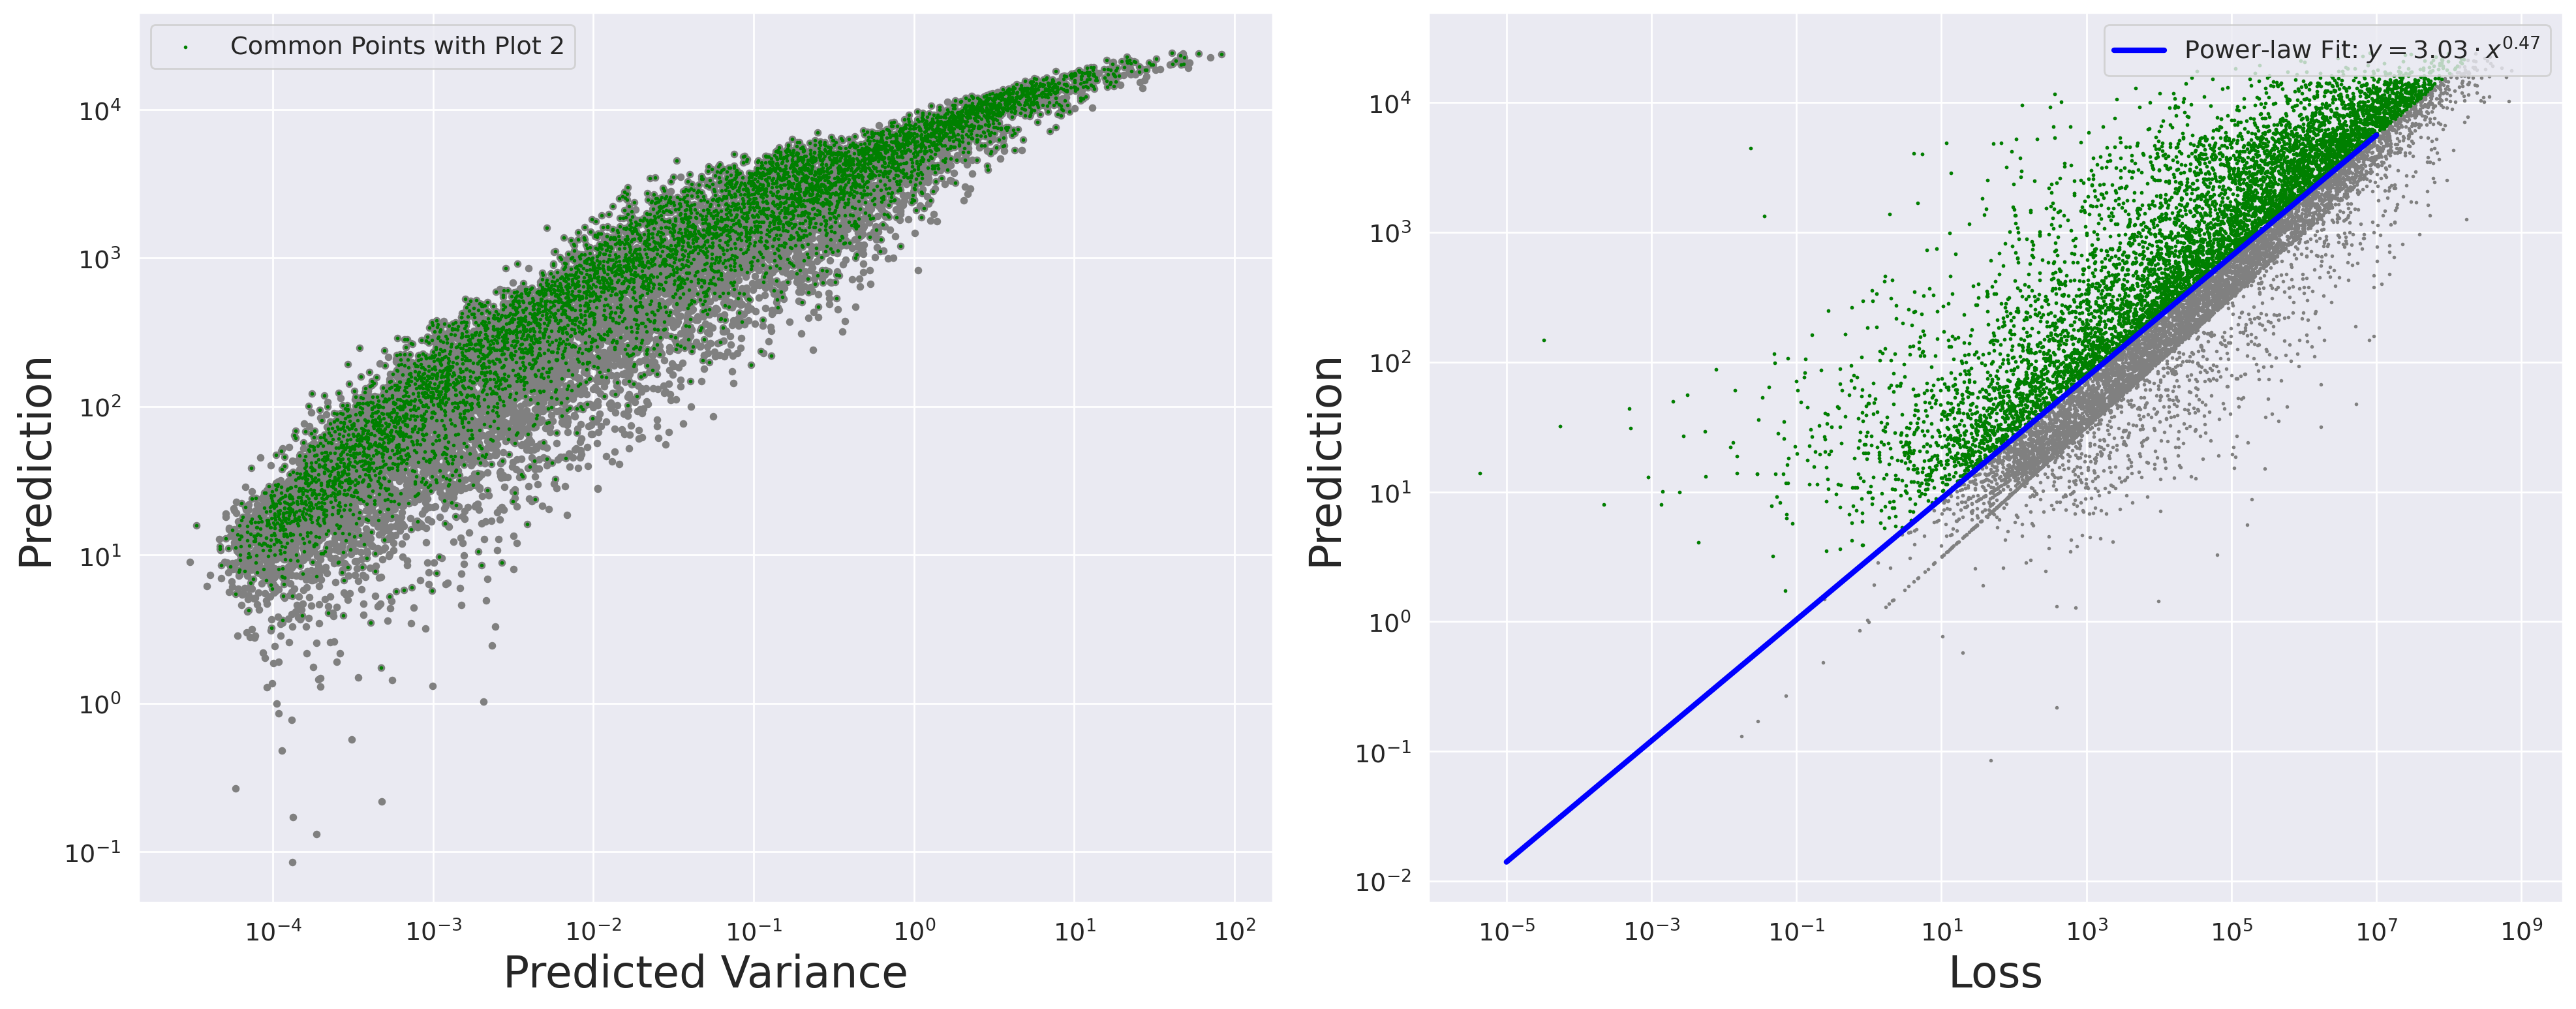

In [73]:
x_values = pred_var

plt.figure(figsize=(20, 8))

# Second Plot
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(loss, pred, color='grey', s=s)  # Default color is grey for all points

# Add a constant to the predictor variable for the intercept term
a2, b2 = fit_power_law(loss, pred, q=0.5, range_start=-5, range_end=7.0)
above_line_reverse = pred > power_law(loss, a2, b2)

#a2, b2 = fit_linear_law(loss, pred, q=0.7, range_start=0, range_end=1000000000, a_i=-1000, b_i=1)
#above_line_reverse = pred > linear_law(loss, a2, b2)

ax2.scatter(loss[above_line_reverse], pred[above_line_reverse], color='green', s=s)


ax2.legend(loc='upper right')
ax2.set_xlabel("Loss", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')


########################

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(x_values, pred, color='grey', s=10)  # Default color is grey for all points
# Identify points above the line and color them red

# Highlight the points in the second plot that are also in the first plot
common_points = np.isin(x_values, x_values[above_line_reverse])
ax2.scatter(x_values[common_points], pred[common_points], color='green', s=s, label='Common Points with Plot 2')
#ax2.set_xscale('log')
#ax2.set_yscale('linear')


plot_stuff(x_log=True, y_log=True)
#plot_stuff()

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/ScatterAleatoricPointsAboveLine.png', format='png', dpi=200)
plt.show()

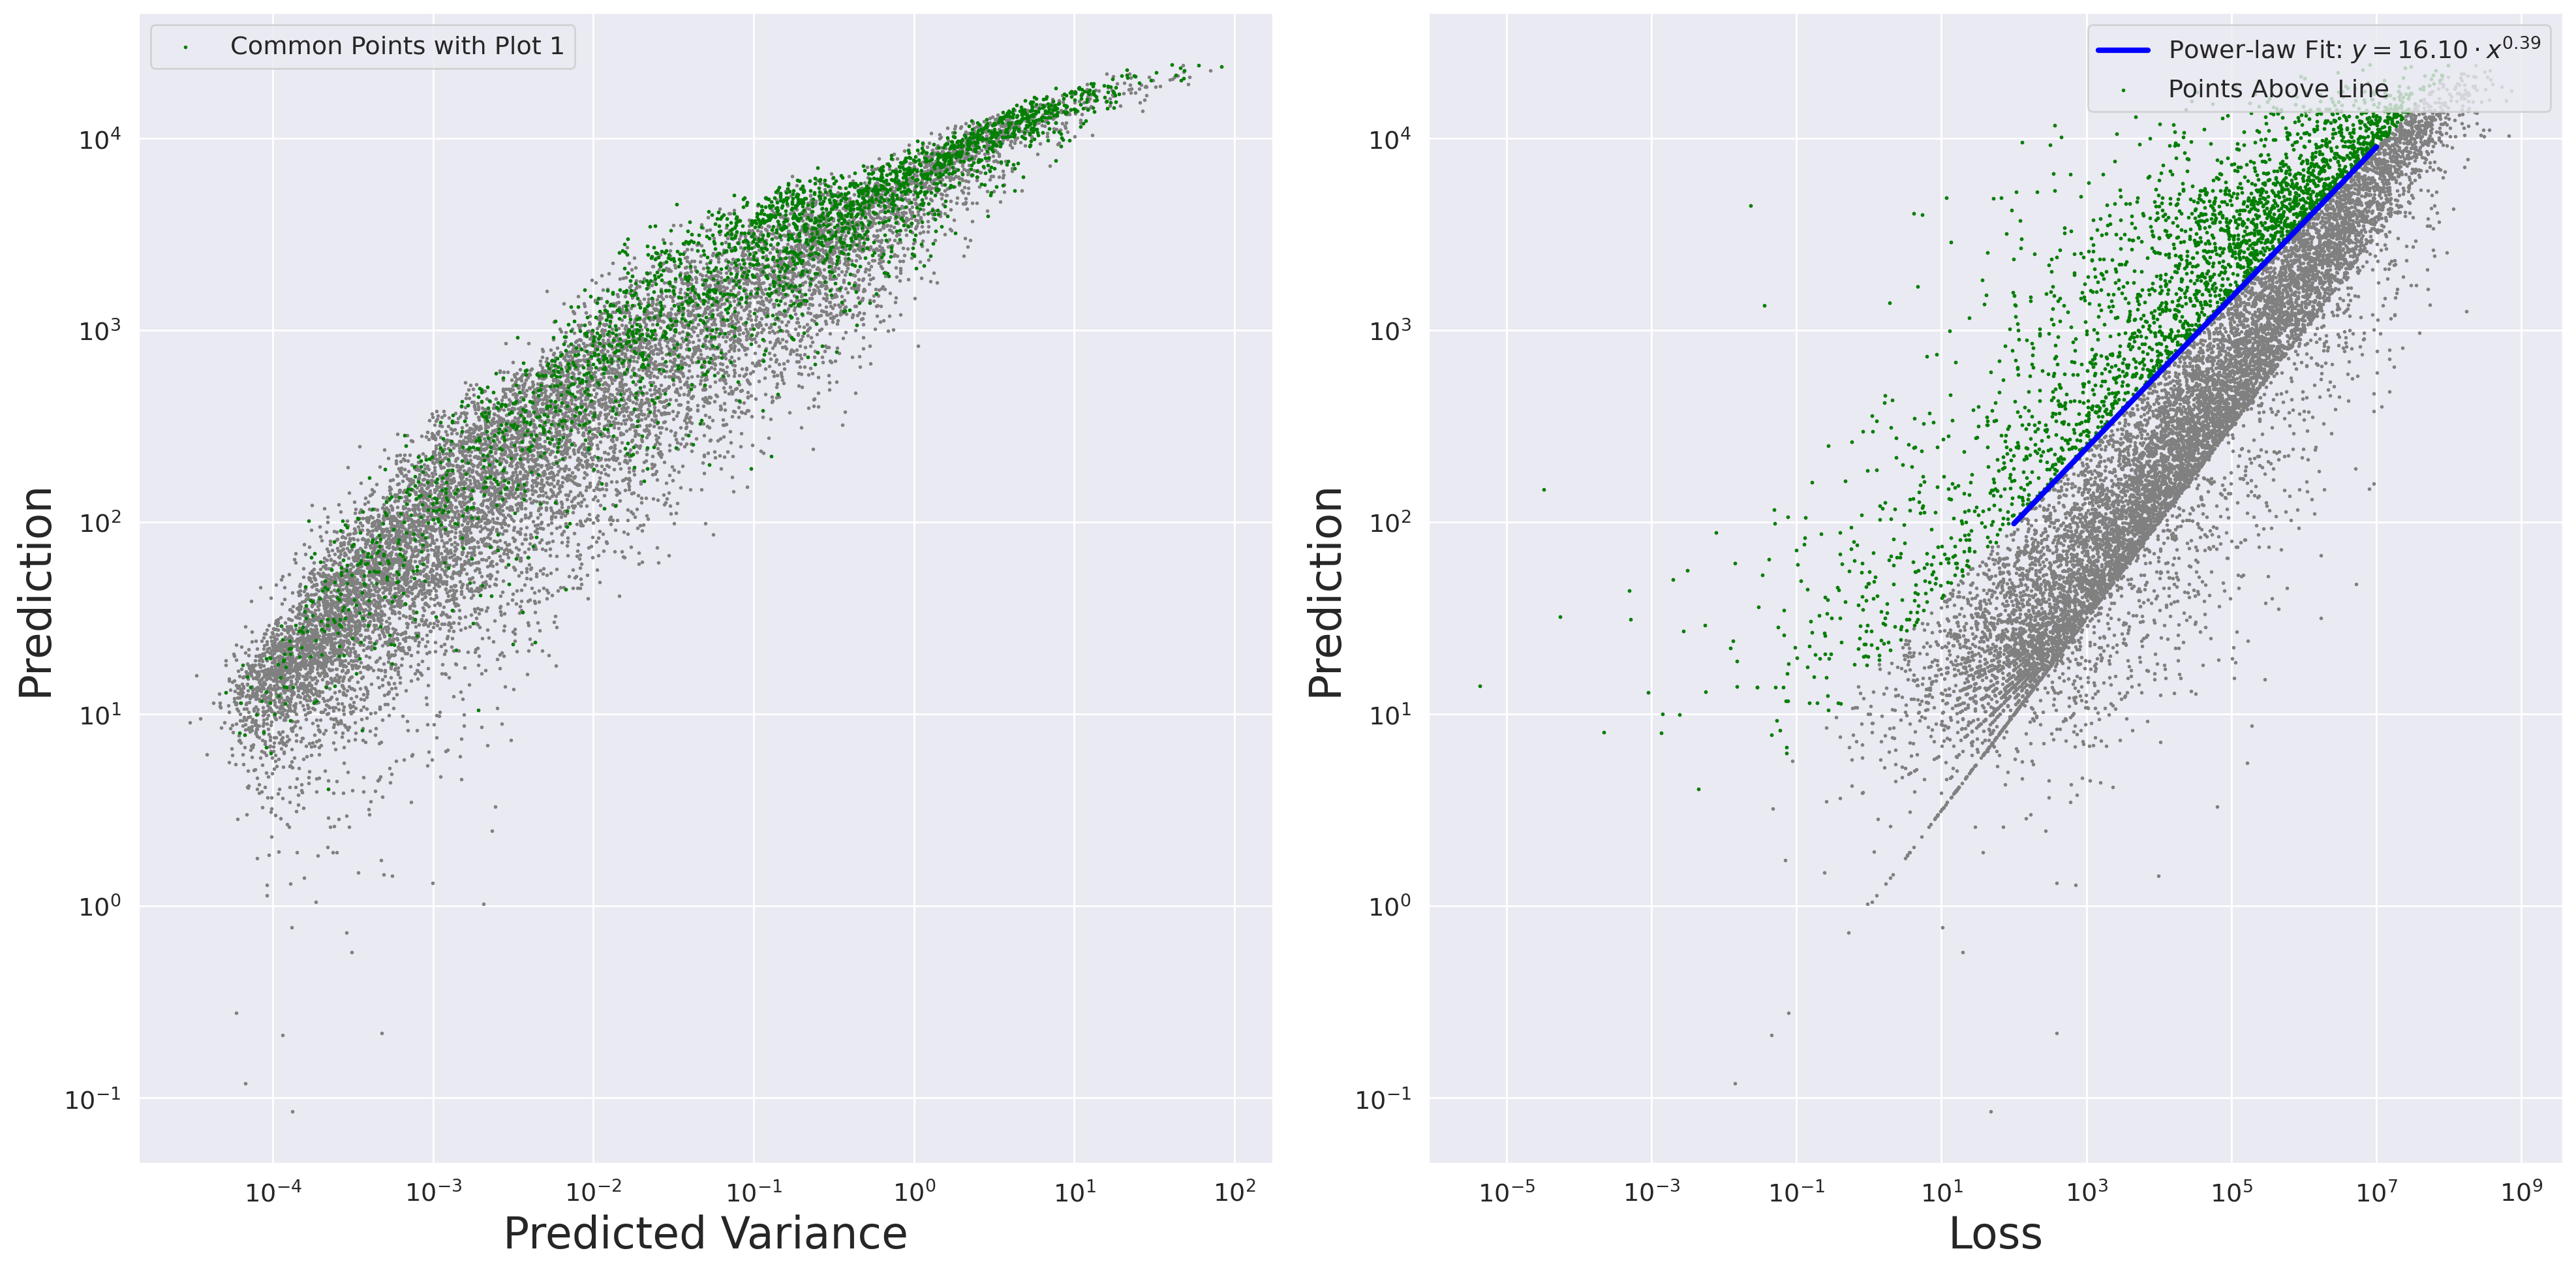

In [40]:
x_values = pred_var

plt.figure(figsize=(20, 10))

# Second Plot
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(loss, pred, color='grey', s=s)  # Default color is grey for all points

# Add a constant to the predictor variable for the intercept term
a2, b2 = fit_power_law(loss, pred, q=0.8, range_start=2, range_end=7.0)
above_line_reverse = pred > power_law(loss, a2, b2)

ax2.scatter(loss[above_line_reverse], pred[above_line_reverse], color='green', s=s, label='Points Above Line')

ax2.legend(loc='upper right')
ax2.set_xlabel("Loss", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')


########################

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(x_values, pred, color='grey', s=s)  # Default color is grey for all points
# Identify points above the line and color them red

# Highlight the points in the second plot that are also in the first plot
common_points = np.isin(x_values, x_values[above_line_reverse])
ax2.scatter(x_values[common_points], pred[common_points], color='green', s=s, label='Common Points with Plot 1')

plot_stuff(x_log=True, y_log=True)
#plot_stuff()

plt.tight_layout()
plt.show()

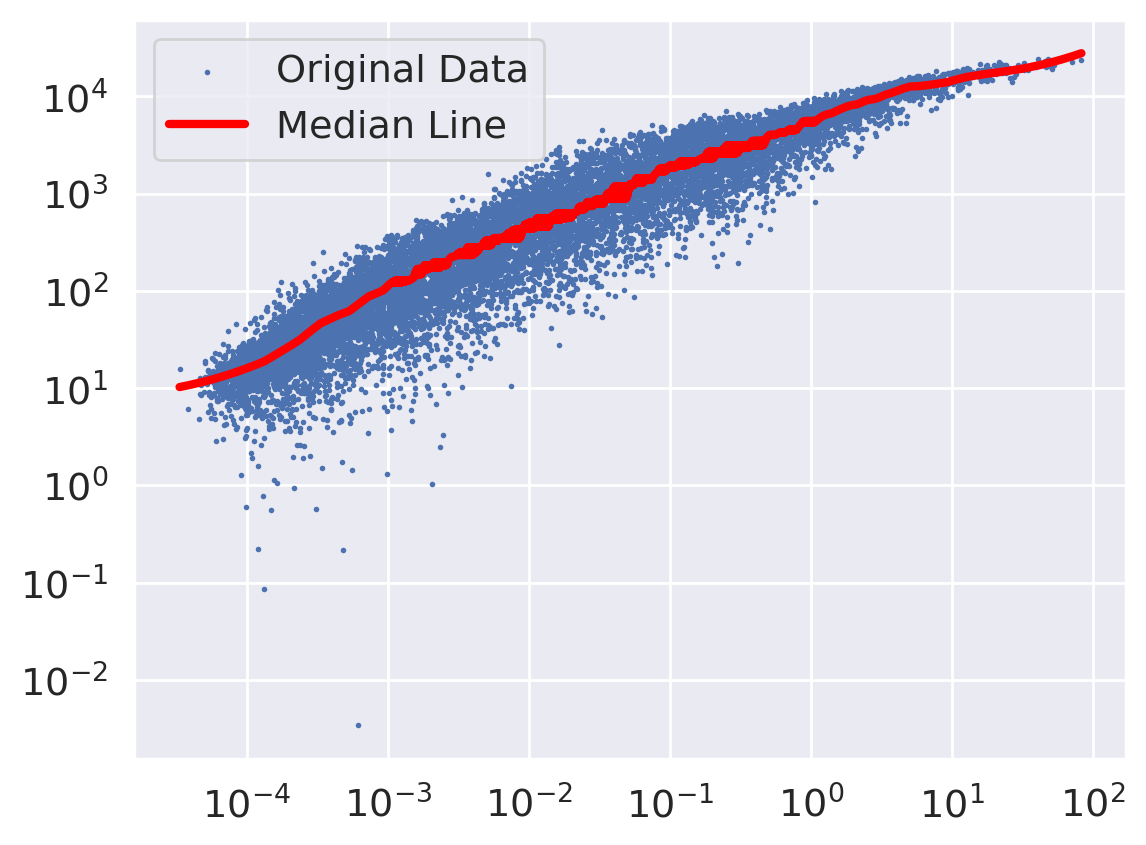

In [43]:
# Apply LOWESS
lowess = sm.nonparametric.lowess(pred, pred_var, frac=0.01, is_sorted=False, delta=0.0001)

# Plot the original data
plt.scatter(pred_var, pred, label='Original Data', s=1)

df = pd.DataFrame({'x': lowess[:, 0], 'y': lowess[:, 1]})

# Group by y-values and calculate the median x-value for each group
median_line = df.groupby('y')['x'].median().reset_index()

plt.plot(median_line['x'], median_line['y'], label='Median Line', color='red', linewidth=3)

# Plot the LOWESS line
#plt.plot(lowess[:, 0], lowess[:, 1], color='red', label='LOWESS Line')

# Show the plot
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [80]:
# New point (x, y)
new_point = (10, 14940)

# Interpolate the smoothed values for the x-coordinate of the new point
smoothed_values = np.interp(new_point[0], lowess[:, 0], lowess[:, 1])

# Compare the y-coordinate of the new point with the interpolated smoothed value
if new_point[1] > smoothed_values:
    print("The new point is above the lowess line.")
elif new_point[1] < smoothed_values:
    print("The new point is below the lowess line.")
else:
    print("The new point is on the lowess line.")

The new point is above the lowess line.


In [81]:
# Create an interpolation function using scipy's interp1d
interp_function = interp1d(lowess[:, 0], lowess[:, 1], kind='linear', fill_value='extrapolate')

# Example: Use the interpolation function for multiple points
new_points = [(10, 14000), (10, 14500), (10, 15000)]  # Replace with your actual points

for new_point in new_points:
    x_coord, y_coord = new_point
    interpolated_value = interp_function(x_coord)

    if y_coord > interpolated_value:
        print(f"The point {new_point} is above the lowess line.")
    elif y_coord < interpolated_value:
        print(f"The point {new_point} is below the lowess line.")
    else:
        print(f"The point {new_point} is on the lowess line.")

The point (10, 14000) is above the lowess line.
The point (10, 14500) is above the lowess line.
The point (10, 15000) is above the lowess line.
